In [39]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
%autoreload 2

In [3]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import pandas as pd


import tensorflow as tf
import tf_data

In [4]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")

version=2.3.0, CUDA=True, GPU=True, TPU=False


# Dataset building

In [5]:
# check max number of samples
df_ele_train = pd.read_csv("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/training/records_metadata.txt", sep=';')
df_ele_test = pd.read_csv("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/testing/records_metadata.txt", sep=';')
df_gamma_train = pd.read_csv("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v8/training/records_metadata.txt", sep=';')
df_gamma_test = pd.read_csv("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v8/testing/records_metadata.txt", sep=';')

In [6]:
print( "Ele training: ", df_ele_train[df_ele_train["class"]!=0].n.sum())
print( "Gamma training: ", df_gamma_train[df_gamma_train["class"]!=0].n.sum())
print( "Ele test: ", df_ele_test[df_ele_test["class"]!=0].n.sum())
print( "Gamma test: ", df_gamma_test[df_gamma_test["class"]!=0].n.sum())

print("unmatched training: ",df_ele_train[df_ele_train["class"]==0].n.sum() + df_gamma_train[df_gamma_train["class"]==0].n.sum()  )
print("unmatched testing: ", df_ele_test[df_ele_test["class"]==0].n.sum() + df_gamma_test[df_gamma_test["class"]!=0].n.sum()  )

Ele training:  1434462
Gamma training:  2876024
Ele test:  475617
Gamma test:  478838
unmatched training:  8803679
unmatched testing:  1450785


In [7]:
data_path = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/training/calo_matched/*.proto",
             #"gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
             #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }

In [8]:
features = [ "en_cluster","et_cluster",
            "cluster_eta", "cluster_phi", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cluster_den_seed","cluster_det_seed",
            "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
            "cl_f5_sigmaIphiIphi","cl_f5_swissCross",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

window_features = [  "max_en_cluster","max_et_cluster","max_deta_cluster","max_dphi_cluster","max_den_cluster","max_det_cluster",
                         "min_en_cluster","min_et_cluster","min_deta_cluster","min_dphi_cluster","min_den_cluster","min_det_cluster",
                         "mean_en_cluster","mean_et_cluster","mean_deta_cluster","mean_dphi_cluster","mean_den_cluster","mean_det_cluster" ]

# Metadata about the window like true energy, true calo position, useful info
window_metadata = ["en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
                    "nclusters_insc",
                    "nVtx", "rho", "obsPU", "truePU",
                    "sim_true_eta", "sim_true_phi",  
                    "en_mustache_raw", "et_mustache_raw","en_mustache_calib", "et_mustache_calib",
                    "event_tot_simen_PU","wtot_simen_PU","wtot_recoen_PU","wtot_simen_sig" ]
    
    

In [9]:
_load_n_items = 10
_batch_size = 6
_nepochs = 1
_ntrain = 10000
_nval = 1000

In [16]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
total_ds = tf_data.load_balanced_dataset_batch(data_path, features,window_features, window_metadata,  _batch_size)
# the indexes for energy and et are from the features list we requestes
# total_ds = tf_data.delta_energy_seed(total_ds, en_index=0, et_index=1)
total_ds = tf_data.training_format(total_ds, norm=False) 

In [17]:
X,y = tf_data.get(total_ds)

In [27]:
y

(<tf.Tensor: shape=(6, 6, 1), dtype=int64, numpy=
 array([[[1],
         [0],
         [0],
         [0],
         [0],
         [0]],
 
        [[1],
         [0],
         [0],
         [0],
         [0],
         [0]],
 
        [[1],
         [0],
         [1],
         [0],
         [0],
         [0]],
 
        [[1],
         [1],
         [1],
         [0],
         [0],
         [0]],
 
        [[1],
         [0],
         [1],
         [0],
         [0],
         [0]],
 
        [[1],
         [0],
         [0],
         [0],
         [0],
         [0]]])>, <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
 array([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], dtype=float32)>, <tf.Tensor: shape=(6, 23), dtype=float32, numpy=
 array([[ 7.7374554e+02,  9.6149506e+01,  7.9259711e+02,  9.8492096e+01,
          1.0000000e+00,  4.3000000e+01,  3.5057693e+01,  5.5000000e+01,
          6.4415710e+01,  2.774602

In [28]:
in_sc, w_flavour, wind_meta = y

In [31]:
wind_meta

<tf.Tensor: shape=(6, 23), dtype=float32, numpy=
array([[ 7.7374554e+02,  9.6149506e+01,  7.9259711e+02,  9.8492096e+01,
         1.0000000e+00,  4.3000000e+01,  3.5057693e+01,  5.5000000e+01,
         6.4415710e+01,  2.7746029e+00,  2.6267931e+00,  7.3067609e+02,
         9.1033028e+01,  7.7142419e+02,  9.6109734e+01,  2.8286548e+03,
         5.3555832e+00,  7.3067609e+02,  7.2345172e+02,  2.7719917e+00,
         9.1033028e+01,  2.0000000e+00,  1.1000000e+01],
       [ 3.6591638e+02,  6.8864700e+01,  3.7612186e+02,  7.0785347e+01,
         1.0000000e+00,  4.5000000e+01,  4.0774883e+01,  5.6000000e+01,
         6.0961594e+01,  2.3544338e+00,  3.0398324e-01,  3.8385596e+02,
         7.2221321e+01,  3.9323453e+02,  7.3985870e+01,  3.2558630e+03,
         6.4080834e+00,  3.8522235e+02,  3.5675165e+02,  2.3545516e+00,
         7.1965591e+01,  2.0000000e+00,  1.1000000e+01],
       [ 6.1017071e+01,  1.4288750e+01,  7.2604370e+01,  1.7002220e+01,
         2.0000000e+00,  4.6000000e+01,  3.28

In [20]:
cl_X,cl_hits, wind_X, is_seed,n_cl = X

# Graph building layer

In [67]:
from model import *
from plotting import * 

In [68]:
graph = GraphBuilding(output_dim_nodes=32)

In [54]:
rcn = RechitsGCN(nconv=3, input_dim = 4 , output_dim =12)

In [55]:
rechits = cl_hits.to_tensor()
mask_rechits, mask_cls = create_padding_masks(rechits)

In [56]:
output, (sa_output,convout, attention_weights, adj) = rcn(rechits, mask_rechits)

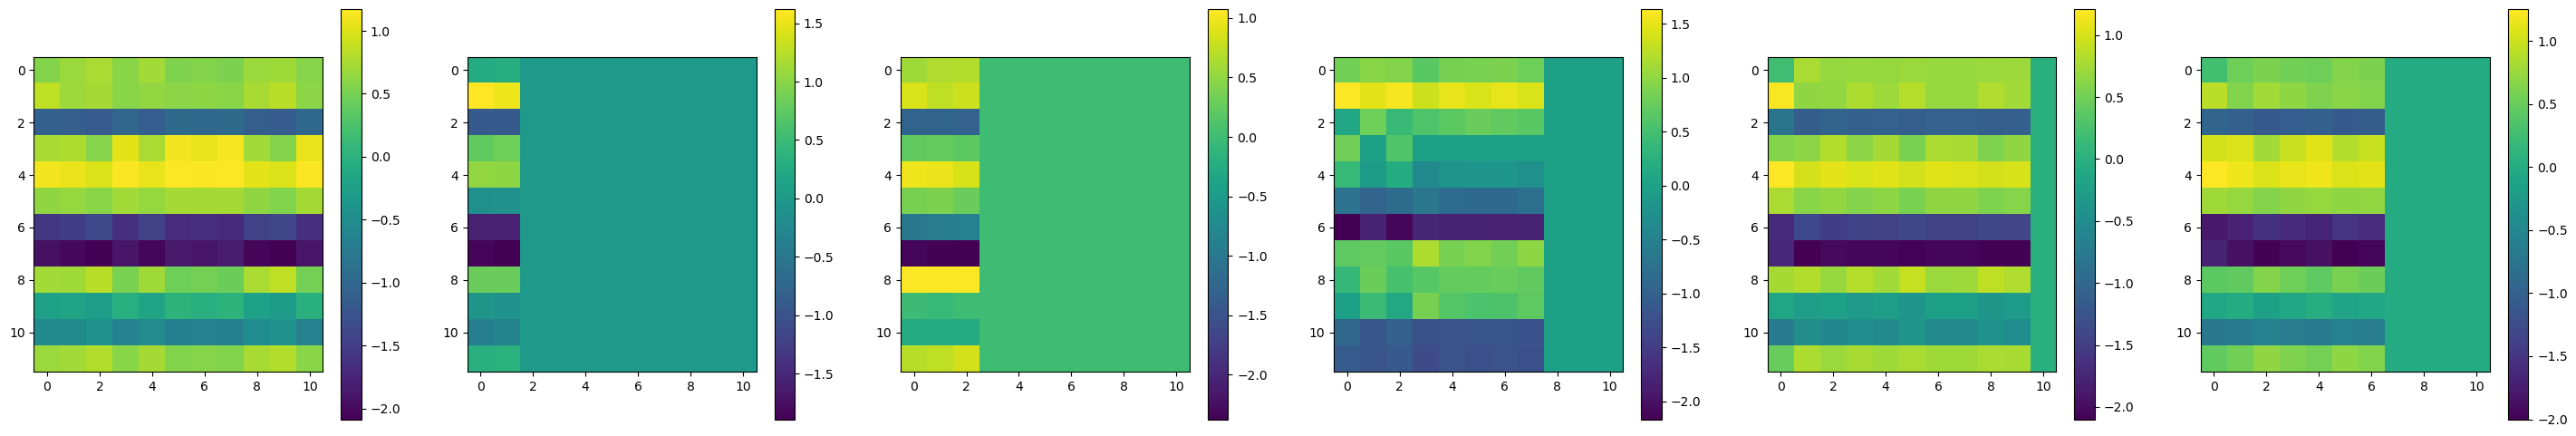

In [58]:
plotM(*output)

In [70]:
cl_x, coord, adj, mask, output_rechits, coord_att_ws = graph(X[0],X[1])

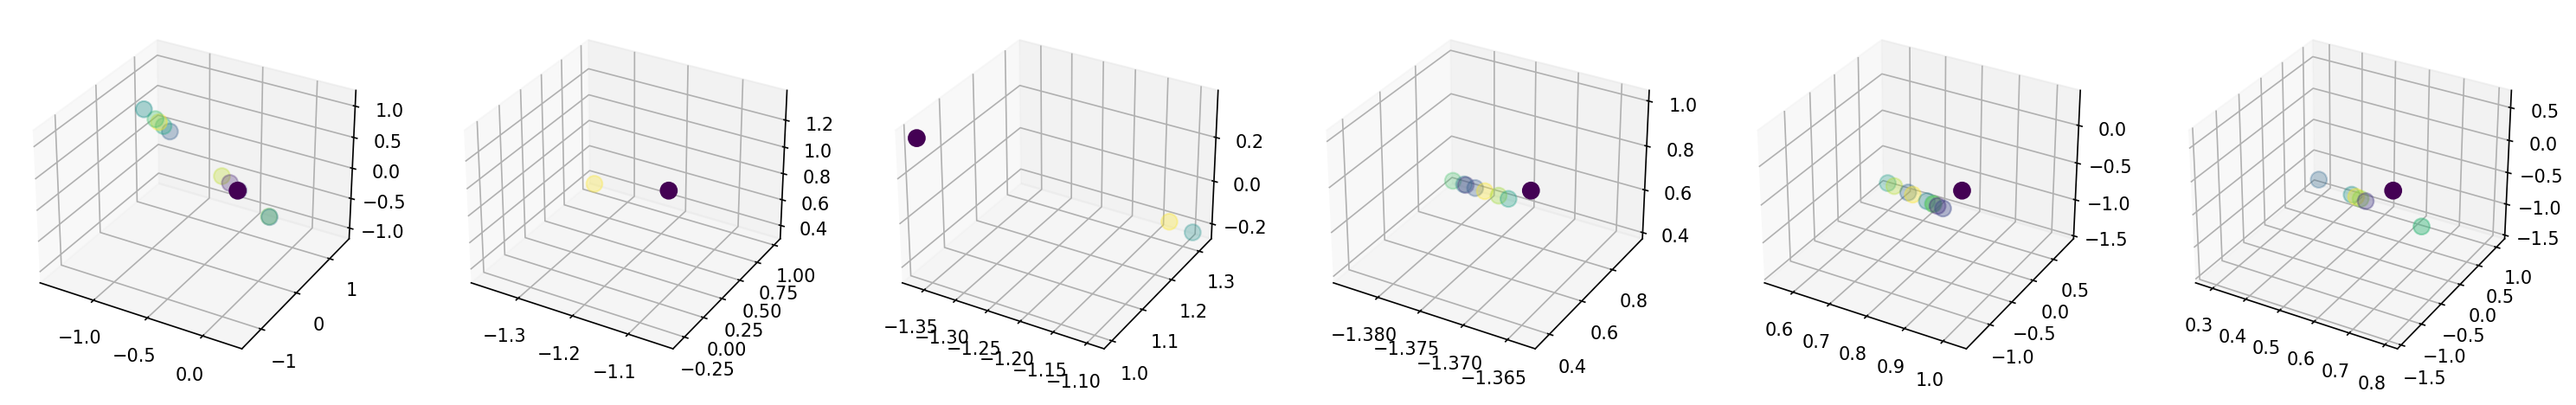

In [71]:
plot3D(coord, mask)

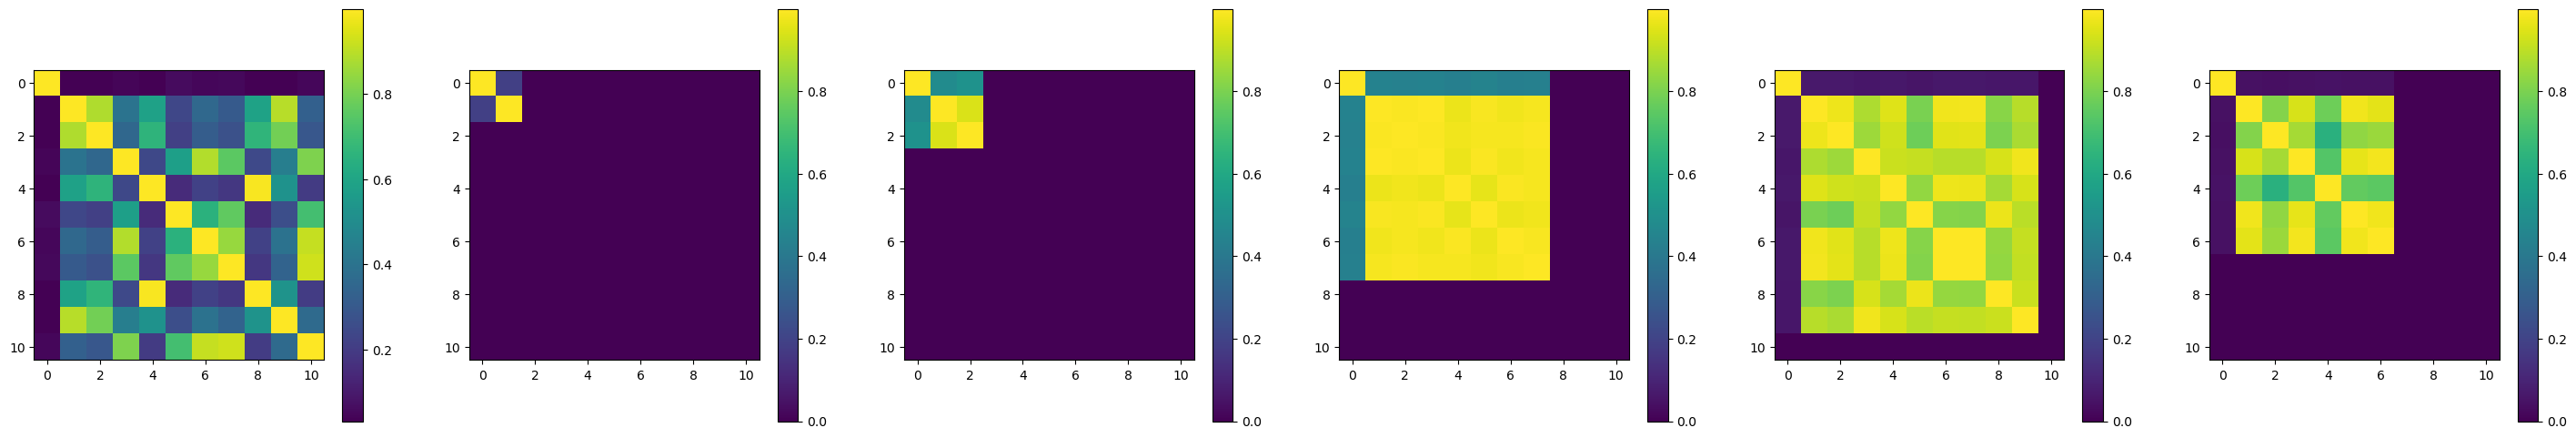

In [72]:
plotM(*adj)

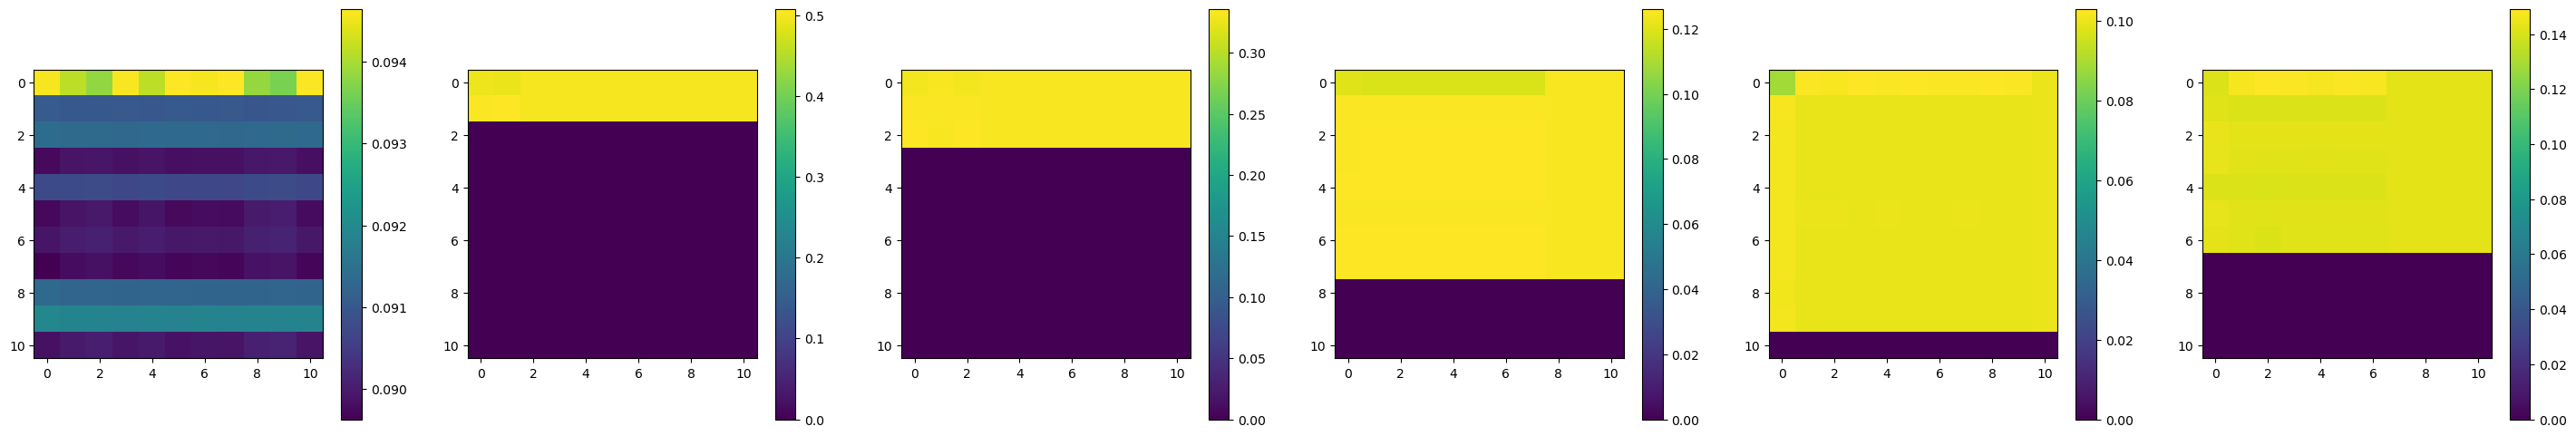

In [75]:
plotM(*coord_att_ws)

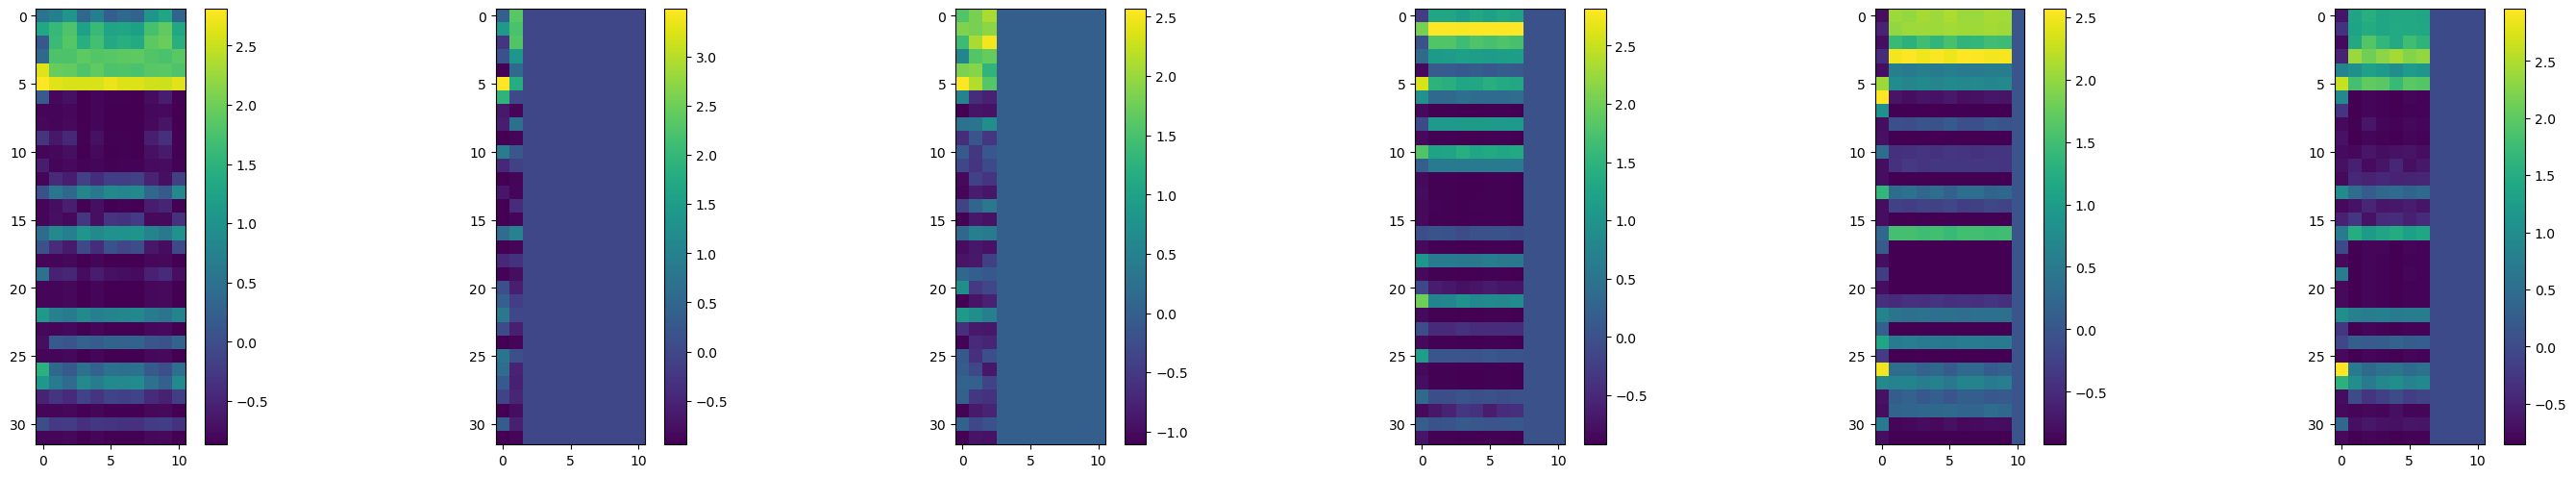

In [93]:
plotM(*cl_x)

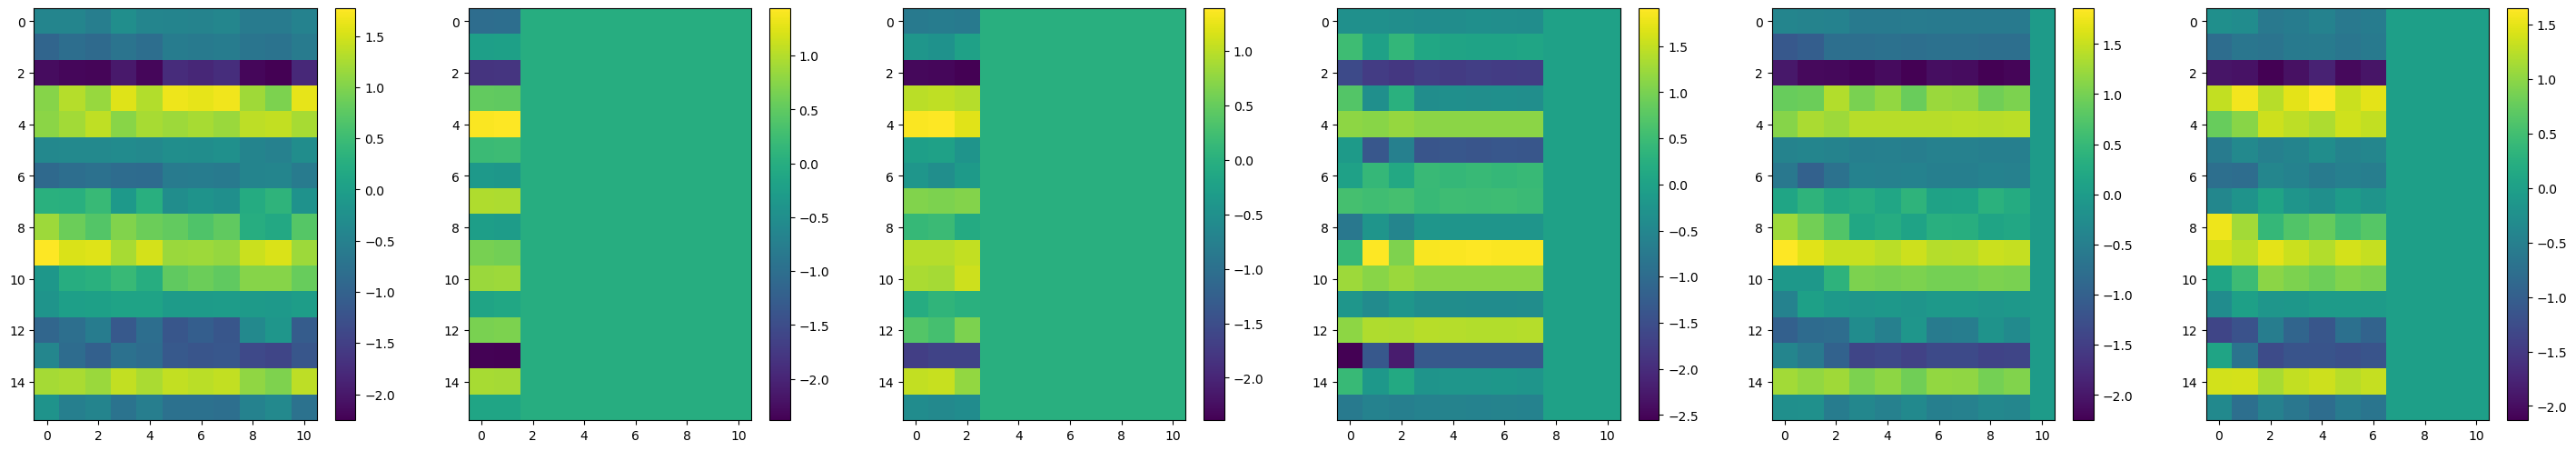

In [74]:
plotM(*output_rechits)

# Complete model

In [80]:
from model import *
from plotting import * 

In [81]:
# output_dim_nodes == latent spoace dimension for the clusters
dcgn = DeepClusterGN(nconv=3, output_dim_nodes=32, layers_input=[64,64,64], layers_coord=[64,64,64,64])

In [27]:
a = model(X)

In [58]:
X, y = tf_data.get(ds_train)

In [83]:
X,y = tf_data.get(ds_test)

In [164]:
X,y = tf_data.get(special_ds)

In [165]:
dense_clclass, windclass, mask_cls, (cl_X, coord, adj, coord_att_ws, output_rechits, out_gcn, out_SAcl ,out_SAw, att_weights_clcall, att_w_windclass) = model(X)

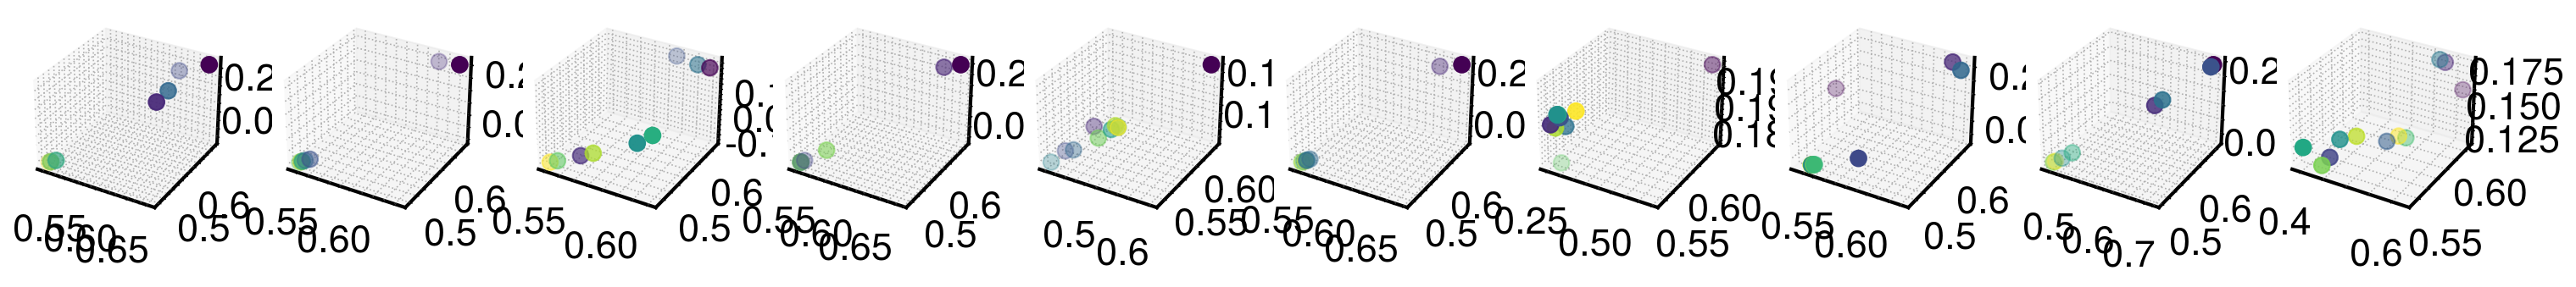

In [166]:
plot3D(coord[0:10], mask_cls)

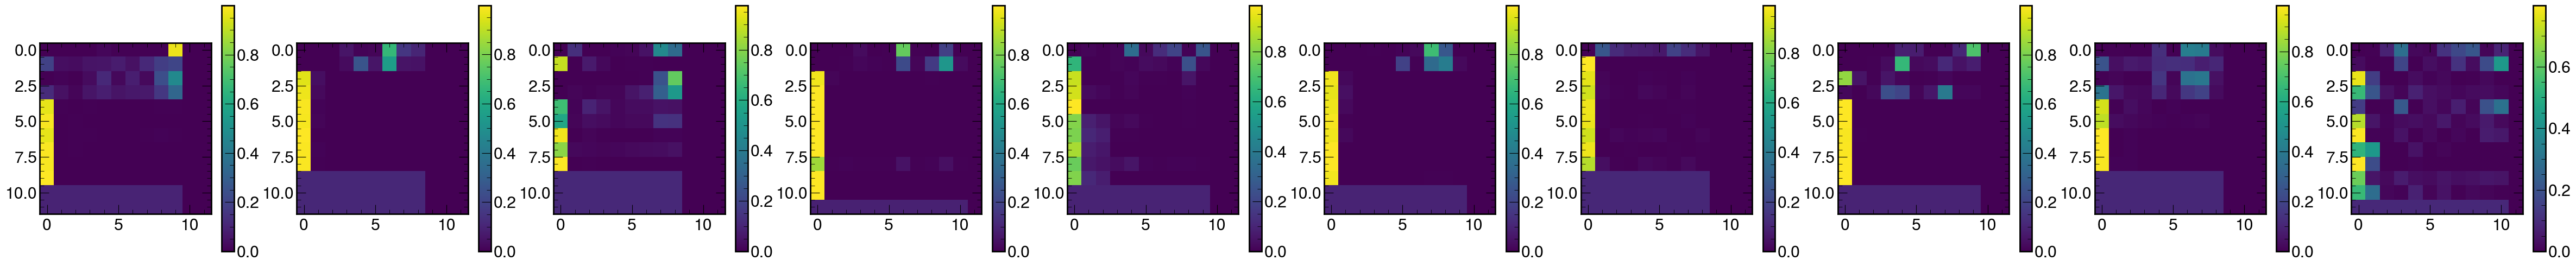

In [167]:
plotM(*coord_att_ws[0:10], t=False)

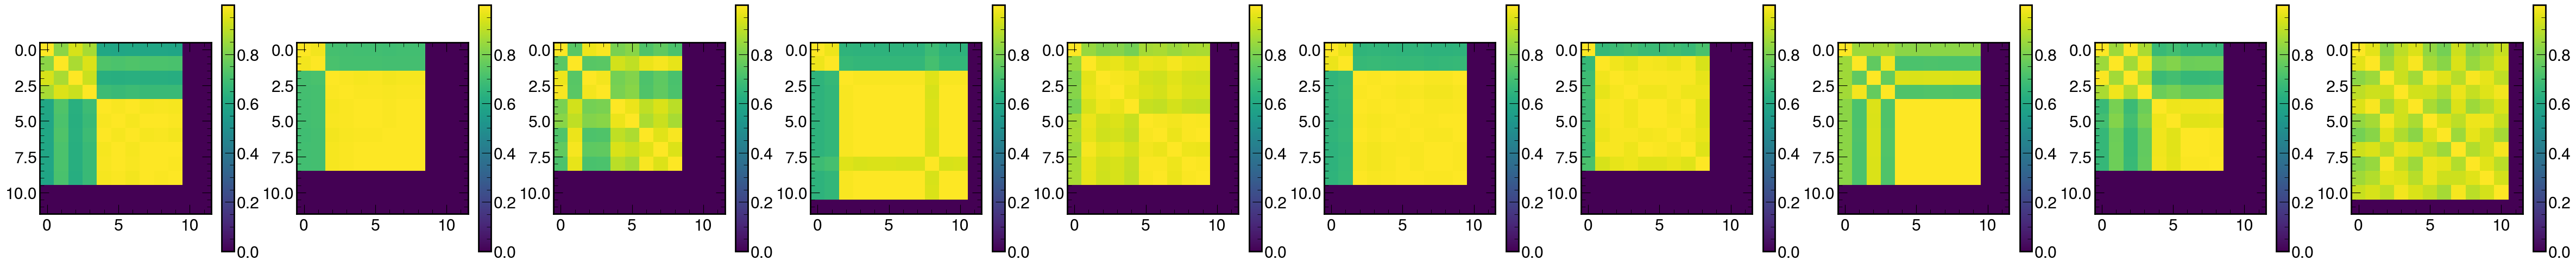

In [168]:
plotM(*adj[0:10])

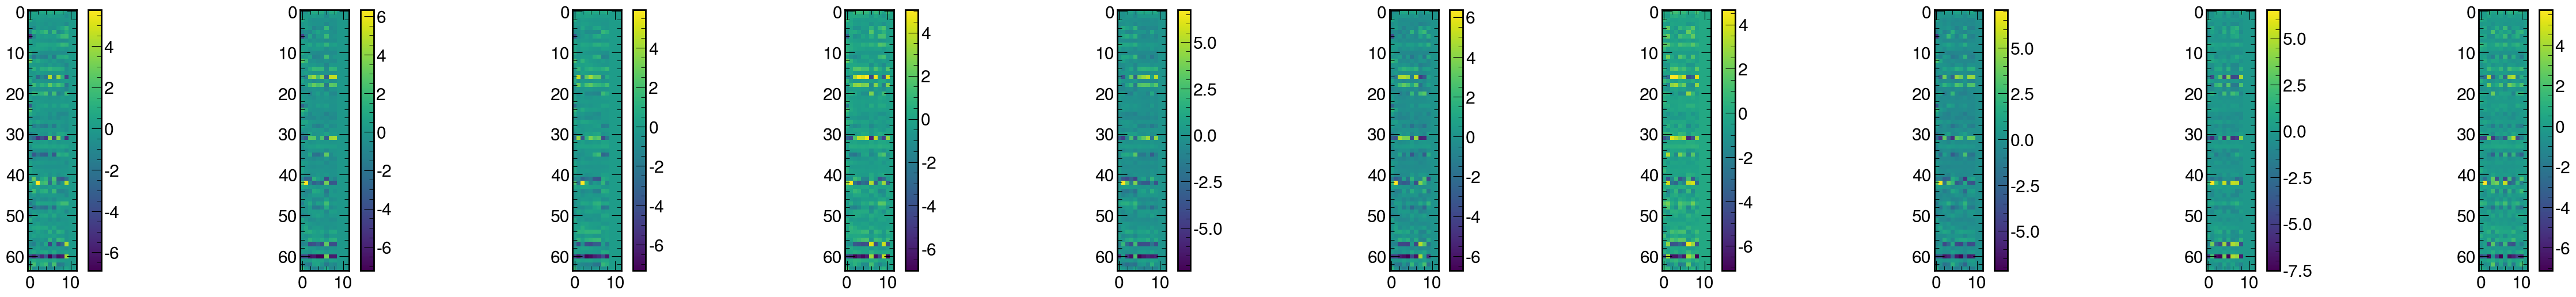

In [169]:
plotM(*cl_X[0:10])

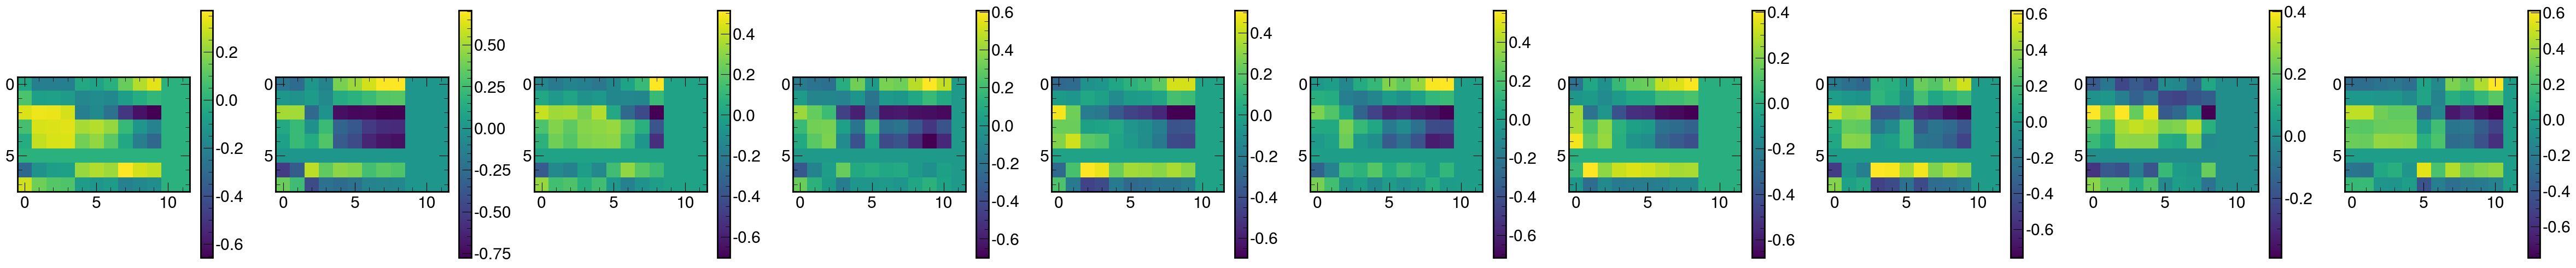

In [170]:
plotM(*output_rechits[0:10])

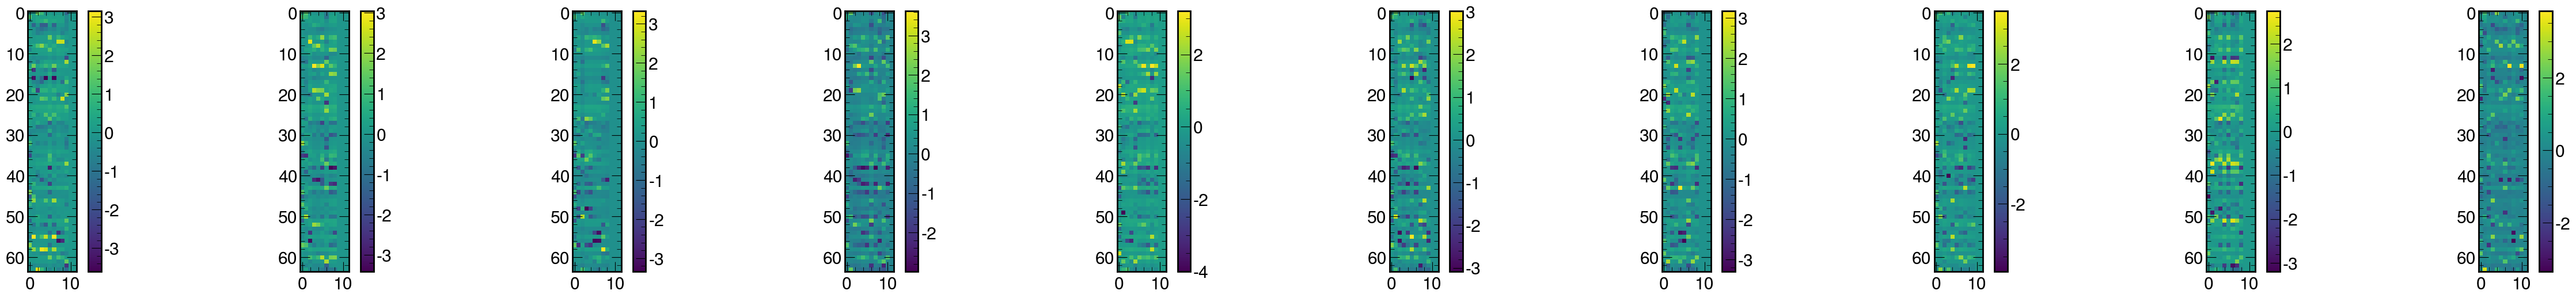

In [171]:
plotM(*out_gcn[0:10])

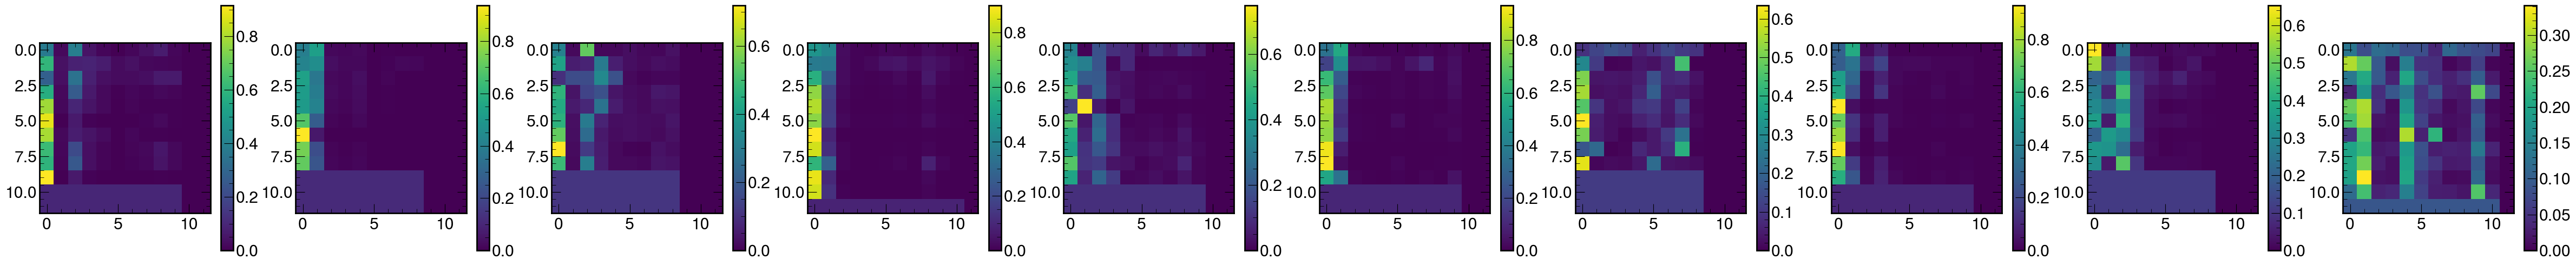

In [172]:
plotM(*att_weights_clcall[0:10], t=False)

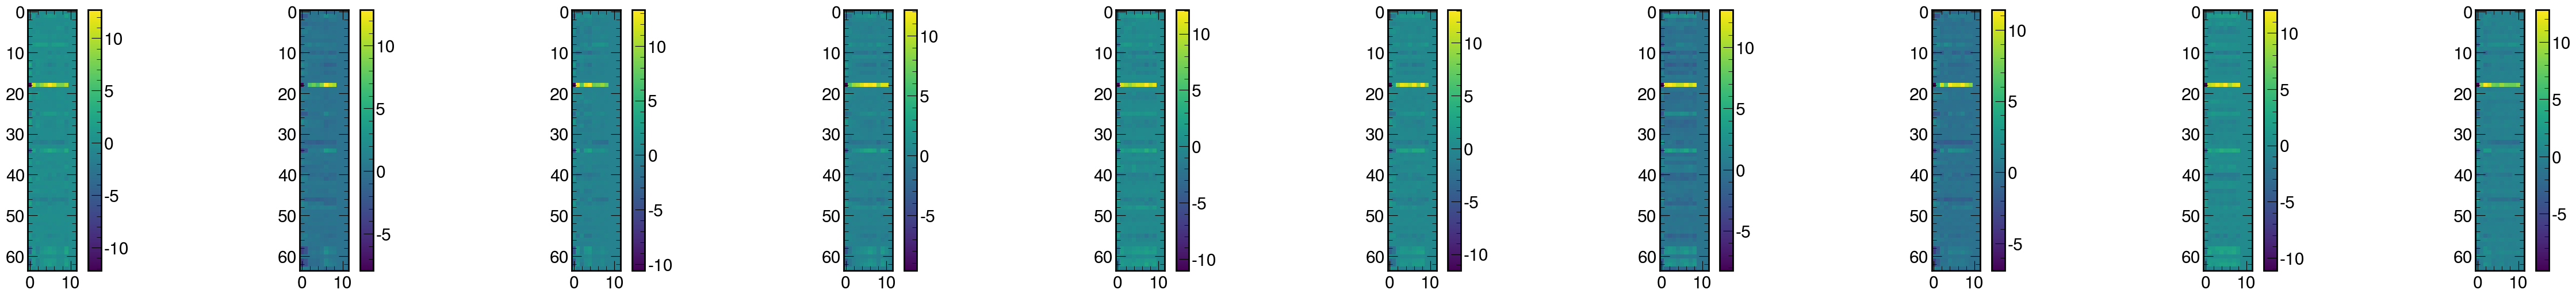

In [173]:
plotM(*out_SAcl[0:10])

In [174]:
tf.nn.sigmoid(dense_clclass)[9]

<tf.Tensor: shape=(12, 1), dtype=float32, numpy=
array([[0.99999964],
       [0.9353494 ],
       [0.00209087],
       [0.00571411],
       [0.8997638 ],
       [0.63838583],
       [0.2028188 ],
       [0.04520874],
       [0.04970368],
       [0.64886534],
       [0.07895858],
       [0.5       ]], dtype=float32)>

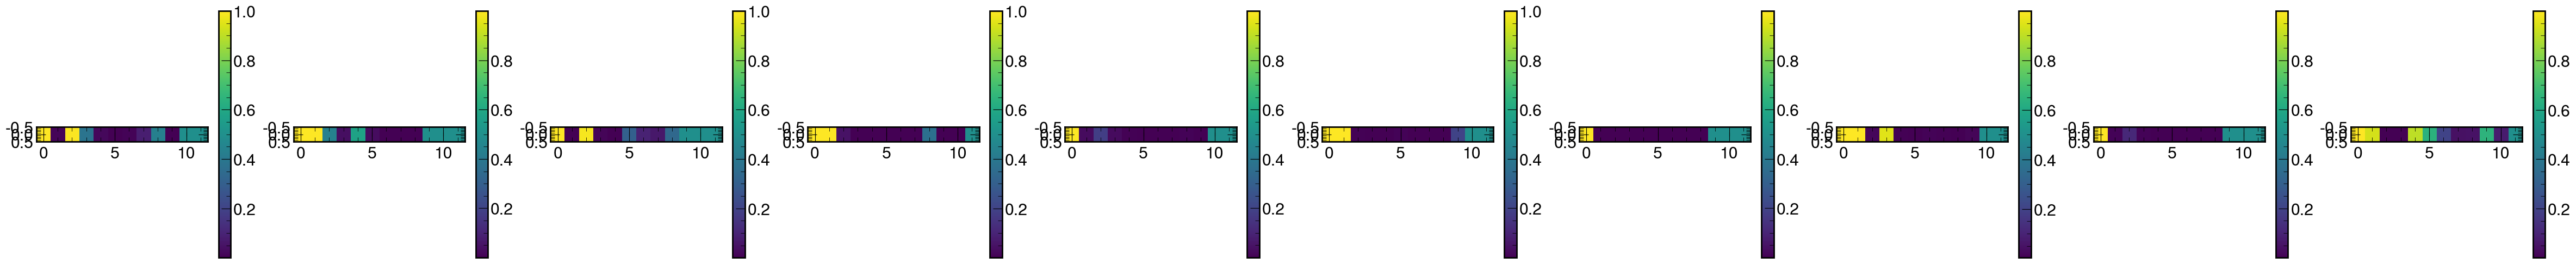

In [175]:
plotM(*tf.nn.sigmoid(dense_clclass)[0:10])

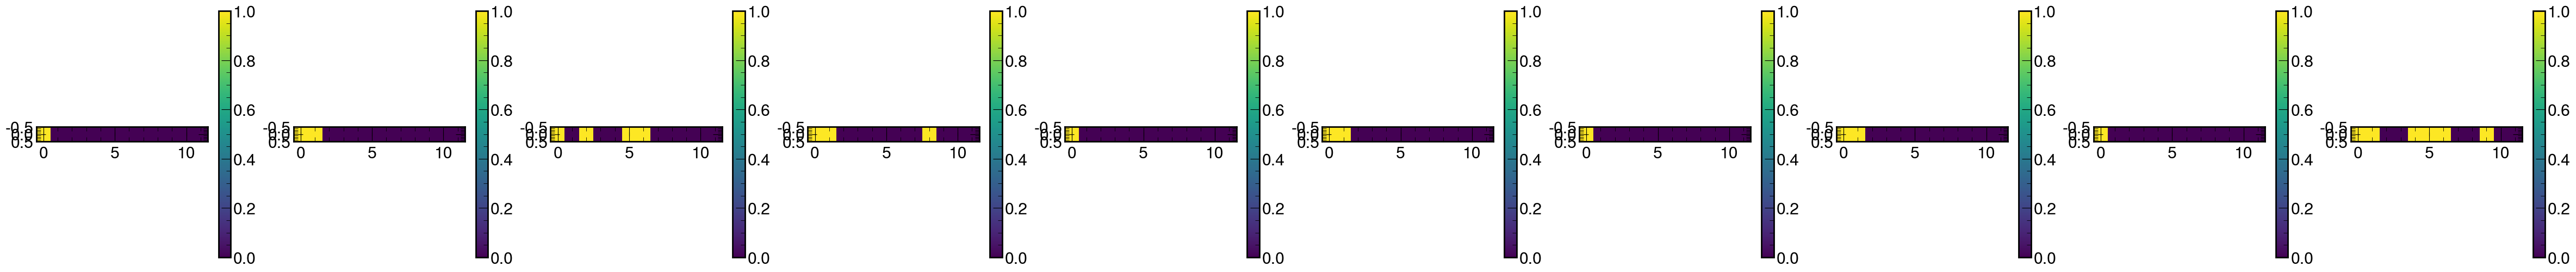

In [176]:
plotM(*y[0][0:10])

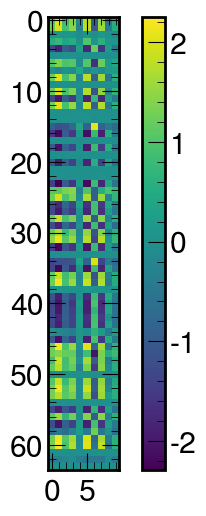

In [177]:
plotM(out_SAw[0:10])

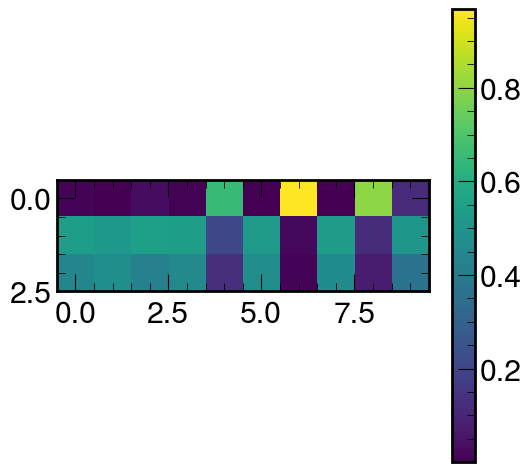

In [178]:
plotM(tf.nn.softmax(windclass[0:10]))

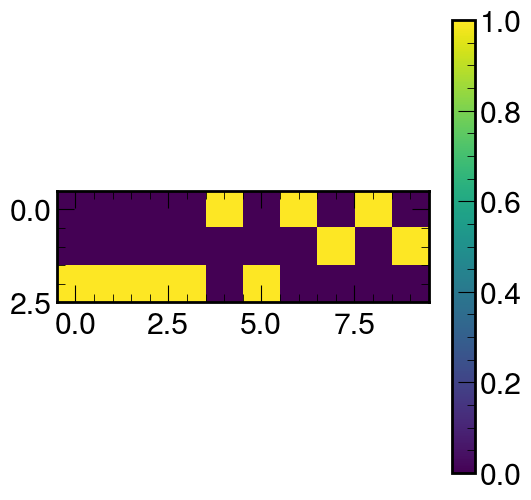

In [179]:
plotM(y[1][0:10])

# Test training

In [75]:
from model import *
from plotting import * 

- Ele training:  199254
- Gamma training:  299529
- Ele test:  38275
- Gamma test:  26130
- unmatched training:  758757
- unmatched testing:  84404

In [58]:
models_path = "/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
# Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
#                             'n_seed_features','batch_size','lr_decay','lr',
#                             'hidden_dim_input','hidden_dim_coord', 'hidden_dim_id',
#                             'n_layers_input', 'n_layers_id', 'n_layers_coord',
#                            'distance_dim','num_conv','dropout','convlayer',
#                            'nclass_labels', 'opt'])
Args = namedtuple('args', [ 'models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'activation', 
                           'output_dim_rechits', 'output_dim_nodes', 'output_dim_gconv', 'output_dim_sa_clclass',
                           'output_dim_sa_windclass','coord_dim','coord_dim_sa','nconv_rechits','nconv', 
                           'layers_input','layers_clclass','layers_windclass','n_windclasses',
                          'dropout','l2_reg','loss_clusters','loss_window','loss_softF1','loss_et_miss','loss_et_spur'])


args = Args( 
models_path = models_path,
load = False,
initial_epoch = 0,
nepochs = 100,
ntrain = 1000000,
nval = 200000,
lr_decay = 0.,
lr = 1e-3,
batch_size = 512,
opt='nadam',
    
activation = tf.keras.activations.elu,
output_dim_rechits = 8,
output_dim_nodes = 64,
output_dim_gconv = 64,
output_dim_sa_clclass = 64,
output_dim_sa_windclass = 64,
coord_dim = 3,
coord_dim_sa = 10,
nconv_rechits = 4,
nconv = 3,
layers_input = [128,64,64],
layers_clclass = [64,64,32],
layers_windclass = [64,64,32],
n_windclasses = 3, 
dropout = 0.25,
l2_reg = True, 
    
loss_clusters= 1.,
loss_window= 1, 
loss_softF1= 1.,
loss_et_miss= 1., 
loss_et_spur= 1.
)

### Dataset loading

In [59]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number


if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print(outdir)

/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/run_02


In [60]:
data_path_train = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/training/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v8/training/calo_matched/*.proto",
                  "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/training/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
                  }
data_path_test = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/testing/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v8/testing/calo_matched/*.proto",
                   "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/testing/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/testing/no_calo_matched/*.proto"
                  }

In [61]:
features = [ "en_cluster","et_cluster",
            "cluster_eta", "cluster_phi", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cluster_den_seed","cluster_det_seed",
            "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
            "cl_f5_sigmaIphiIphi","cl_f5_swissCross",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

window_features = [  "max_en_cluster","max_et_cluster","max_deta_cluster","max_dphi_cluster","max_den_cluster","max_det_cluster",
                         "min_en_cluster","min_et_cluster","min_deta_cluster","min_dphi_cluster","min_den_cluster","min_det_cluster",
                         "mean_en_cluster","mean_et_cluster","mean_deta_cluster","mean_dphi_cluster","mean_den_cluster","mean_det_cluster" ]

# Metadata about the window like true energy, true calo position, useful info
window_metadata = ["en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
                    "nclusters_insc",
                    "nVtx", "rho", "obsPU", "truePU",
                    "sim_true_eta", "sim_true_phi",  
                    "en_mustache_raw", "et_mustache_raw","en_mustache_calib", "et_mustache_calib",
                    "event_tot_simen_PU","wtot_simen_PU","wtot_recoen_PU","wtot_simen_sig" ]
    
    

In [62]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
train_ds = tf_data.load_balanced_dataset_batch(data_path_train, features, window_features, window_metadata, args.batch_size,weights={"ele_match":0.35,"gamma_match":0.35, "nomatch":0.3} )#weights={"ele_match":0.4,"gamma_match":0.4}
# the indexes for energy and et are from the features list we requestes
# train_ds = tf_data.delta_energy_seed(train_ds, en_index=0, et_index=1)
train_ds = tf_data.normalize_features(train_ds, "normalization.npz", "normalization_wind_features.npz")
train_ds = tf_data.training_format(train_ds)


test_ds = tf_data.load_balanced_dataset_batch(data_path_test, features, window_features, window_metadata, args.batch_size,weights={"ele_match":0.35,"gamma_match":0.35, "nomatch":0.3})
# the indexes for energy and et are from the features list we requestes
# test_ds = tf_data.delta_energy_seed(test_ds, en_index=0, et_index=1)
test_ds = tf_data.normalize_features(test_ds, "normalization.npz", "normalization_wind_features.npz")
test_ds = tf_data.training_format(test_ds)

# Create training and validation
ds_train = train_ds.prefetch(200).take(args.ntrain // args.batch_size).repeat(args.nepochs)
ds_test  = test_ds.prefetch(200).take(args.nval // args.batch_size).repeat(args.nepochs)

In [163]:
def filter(d1,d2):
    return  d1["n_cl"] > 8  and d1["s_f"][0] > 1.5 and d1["s_f"][0] < 2.2 and  d1["s_f"][6] < 50

special_ds = tf_data.load_balanced_dataset_batch(data_path_test, features, window_features, window_metadata,  20,filter=filter, weights={"ele_match":0.45,"gamma_match":0.45, "nomatch":0.1})
# the indexes for energy and et are from the features list we requestes
# special_ds = tf_data.delta_energy_seed(special_ds, en_index=0, et_index=1)
special_ds = tf_data.normalize_features(special_ds, "normalization.npz","normalization_wind_features.npz")
special_ds = tf_data.training_format(special_ds)

In [64]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay,
            staircase=True
        )
else:
    lr_schedule = args.lr


In [65]:
def get_model(args, weights=None):

    loss_weights = {"clusters":args.loss_clusters, "window":args.loss_window, 
                    "softF1":args.loss_softF1, "et_miss":args.loss_et_miss, "et_spur":args.loss_et_spur}
    tf.keras.backend.clear_session()

    
    with strategy.scope():
        opt = tf.keras.optimizers.Adam(learning_rate=args.lr)
        # Construction of the model
        model = DeepClusterGN(
                    activation = args.activation,
                    output_dim_rechits = args.output_dim_rechits,
                    output_dim_nodes =args.output_dim_nodes,
                    output_dim_gconv = args.output_dim_gconv,
                    output_dim_sa_clclass = args.output_dim_sa_clclass,
                    output_dim_sa_windclass = args.output_dim_sa_windclass,
                    coord_dim = args.coord_dim,
                    coord_dim_sa = args.coord_dim_sa,
                    nconv_rechits = args.nconv_rechits,
                    nconv = args.nconv,
                    layers_input = args.layers_input,
                    layers_clclass = args.layers_clclass,
                    layers_windclass = args.layers_windclass,
                    n_windclasses = args.n_windclasses,
                    dropout = args.dropout,
                    l2_reg = args.l2_reg,
                    loss_weights= loss_weights
                    )


        model.compile(optimizer=args.opt)
    #         metrics=[Precision(),Recall(), energy_resolution|_insc,energy_resolution_outsc,
    #                      energy_resolution_insc_log,energy_resolution_outsc_log,])
        model.set_metrics()

        for X, y in ds_train:
            ypred = model(X)
            #l = custom_loss(y, ypred)
            break
        
        if weights:
            model.load_weights(weights)
        
        return model

In [76]:
model = get_model(args)

In [77]:
model.summary()

Model: "deep_cluster_gn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_builder (GraphBuilding multiple                  23559     
_________________________________________________________________
GHN_global (GHConvI)         multiple                  8256      
_________________________________________________________________
SA_clclass (SelfAttentionBlo multiple                  24960     
_________________________________________________________________
dense_clclass (Sequential)   (512, 17, 1)              14529     
_________________________________________________________________
SA_windclass (SelfAttentionB multiple                  41344     
_________________________________________________________________
dense_windclass (Sequential) (512, 3)                  10499     
_________________________________________________________________
dropout_18 (Dropout)         multiple              

In [78]:
callbacks = []
tb = tf.keras.callbacks.TensorBoard(
    log_dir=outdir, histogram_freq=2, 
    write_graph=False, 
    write_images=True,
    update_freq='epoch',
    profile_batch=0,
)
tb.set_model(model)
callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1,
    mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-7,
)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=1
)
cp_callback.set_model(model)


early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=5, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)
early.set_model(model)



callbacks += [cp_callback, lr_reduce, early]



In [79]:
if args.load:
    #ensure model input size is known
    for X, y in ds_train:
        model(X)
        break

    model.load_weights(args.load)
    
if args.nepochs > 0:
    ret = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=args.nepochs,
        steps_per_epoch=args.ntrain//args.batch_size, 
        validation_steps=args.nval//args.batch_size,
        verbose=True,
        callbacks = callbacks,
        initial_epoch = args.initial_epoch
    )

Epoch 1/100
1953/1953 [==============================] - ETA: 0s - loss: 3.9299 - loss_clusters: 0.7880 - loss_windows: 0.6750 - loss_softF1: 0.7438 - loss_et_miss: 0.2098 - loss_et_spur: 0.1541
Epoch 00001: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/run_02/weights.01-2.310151.hdf5
1953/1953 [==============================] - 281s 144ms/step - loss: 3.9299 - loss_clusters: 0.7880 - loss_windows: 0.6750 - loss_softF1: 0.7438 - loss_et_miss: 0.2098 - loss_et_spur: 0.1541 - val_loss: 2.3102 - val_loss_clusters: 0.5373 - val_loss_windows: 0.6195 - val_loss_softF1: 0.7302 - val_loss_et_miss: 0.0627 - val_loss_et_spur: 0.0986
Epoch 2/100
1953/1953 [==============================] - ETA: 0s - loss: 2.5102 - loss_clusters: 0.6572 - loss_windows: 0.6486 - loss_softF1: 0.7388 - loss_et_miss: 0.1376 - loss_et_spur: 0.1202
Epoch 00002: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5

Epoch 13/100
1953/1953 [==============================] - ETA: 0s - loss: 2.1076 - loss_clusters: 0.5039 - loss_windows: 0.6266 - loss_softF1: 0.7334 - loss_et_miss: 0.0819 - loss_et_spur: 0.0822
Epoch 00013: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/run_02/weights.13-2.013180.hdf5

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1953/1953 [==============================] - 269s 138ms/step - loss: 2.1076 - loss_clusters: 0.5039 - loss_windows: 0.6266 - loss_softF1: 0.7334 - loss_et_miss: 0.0819 - loss_et_spur: 0.0822 - val_loss: 2.0132 - val_loss_clusters: 0.4616 - val_loss_windows: 0.6162 - val_loss_softF1: 0.7292 - val_loss_et_miss: 0.0610 - val_loss_et_spur: 0.0711
Epoch 14/100
1953/1953 [==============================] - ETA: 0s - loss: 2.0453 - loss_clusters: 0.4805 - loss_windows: 0.6221 - loss_softF1: 0.7321 - loss_et_miss: 0.0770 - loss_et_spur: 0.0750
Epoch 00014: saving model to /eos

Epoch 25/100
1953/1953 [==============================] - ETA: 0s - loss: 2.0018 - loss_clusters: 0.4671 - loss_windows: 0.6189 - loss_softF1: 0.7317 - loss_et_miss: 0.0743 - loss_et_spur: 0.0730
Epoch 00025: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/run_02/weights.25-1.941385.hdf5
1953/1953 [==============================] - 267s 137ms/step - loss: 2.0018 - loss_clusters: 0.4671 - loss_windows: 0.6189 - loss_softF1: 0.7317 - loss_et_miss: 0.0743 - loss_et_spur: 0.0730 - val_loss: 1.9414 - val_loss_clusters: 0.4336 - val_loss_windows: 0.6115 - val_loss_softF1: 0.7292 - val_loss_et_miss: 0.0639 - val_loss_et_spur: 0.0670
Epoch 26/100
1953/1953 [==============================] - ETA: 0s - loss: 2.0001 - loss_clusters: 0.4663 - loss_windows: 0.6189 - loss_softF1: 0.7317 - loss_et_miss: 0.0742 - loss_et_spur: 0.0727
Epoch 00026: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_

Epoch 37/100
1953/1953 [==============================] - ETA: 0s - loss: 1.9800 - loss_clusters: 0.4577 - loss_windows: 0.6147 - loss_softF1: 0.7321 - loss_et_miss: 0.0724 - loss_et_spur: 0.0712
Epoch 00037: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/run_02/weights.37-1.930175.hdf5
1953/1953 [==============================] - 268s 137ms/step - loss: 1.9800 - loss_clusters: 0.4577 - loss_windows: 0.6147 - loss_softF1: 0.7321 - loss_et_miss: 0.0724 - loss_et_spur: 0.0712 - val_loss: 1.9302 - val_loss_clusters: 0.4323 - val_loss_windows: 0.6095 - val_loss_softF1: 0.7290 - val_loss_et_miss: 0.0624 - val_loss_et_spur: 0.0652
Epoch 38/100
1953/1953 [==============================] - ETA: 0s - loss: 1.9800 - loss_clusters: 0.4581 - loss_windows: 0.6151 - loss_softF1: 0.7317 - loss_et_miss: 0.0725 - loss_et_spur: 0.0712
Epoch 00038: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_

Epoch 49/100
1953/1953 [==============================] - ETA: 0s - loss: 1.9690 - loss_clusters: 0.4540 - loss_windows: 0.6127 - loss_softF1: 0.7317 - loss_et_miss: 0.0716 - loss_et_spur: 0.0707
Epoch 00049: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/run_02/weights.49-1.915236.hdf5
1953/1953 [==============================] - 268s 137ms/step - loss: 1.9690 - loss_clusters: 0.4540 - loss_windows: 0.6127 - loss_softF1: 0.7317 - loss_et_miss: 0.0716 - loss_et_spur: 0.0707 - val_loss: 1.9152 - val_loss_clusters: 0.4284 - val_loss_windows: 0.6043 - val_loss_softF1: 0.7289 - val_loss_et_miss: 0.0594 - val_loss_et_spur: 0.0661
Epoch 50/100
1953/1953 [==============================] - ETA: 0s - loss: 1.9663 - loss_clusters: 0.4531 - loss_windows: 0.6122 - loss_softF1: 0.7311 - loss_et_miss: 0.0714 - loss_et_spur: 0.0705
Epoch 00050: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_

In [80]:
import mplhep as hep
plt.style.use(hep.style.CMS)

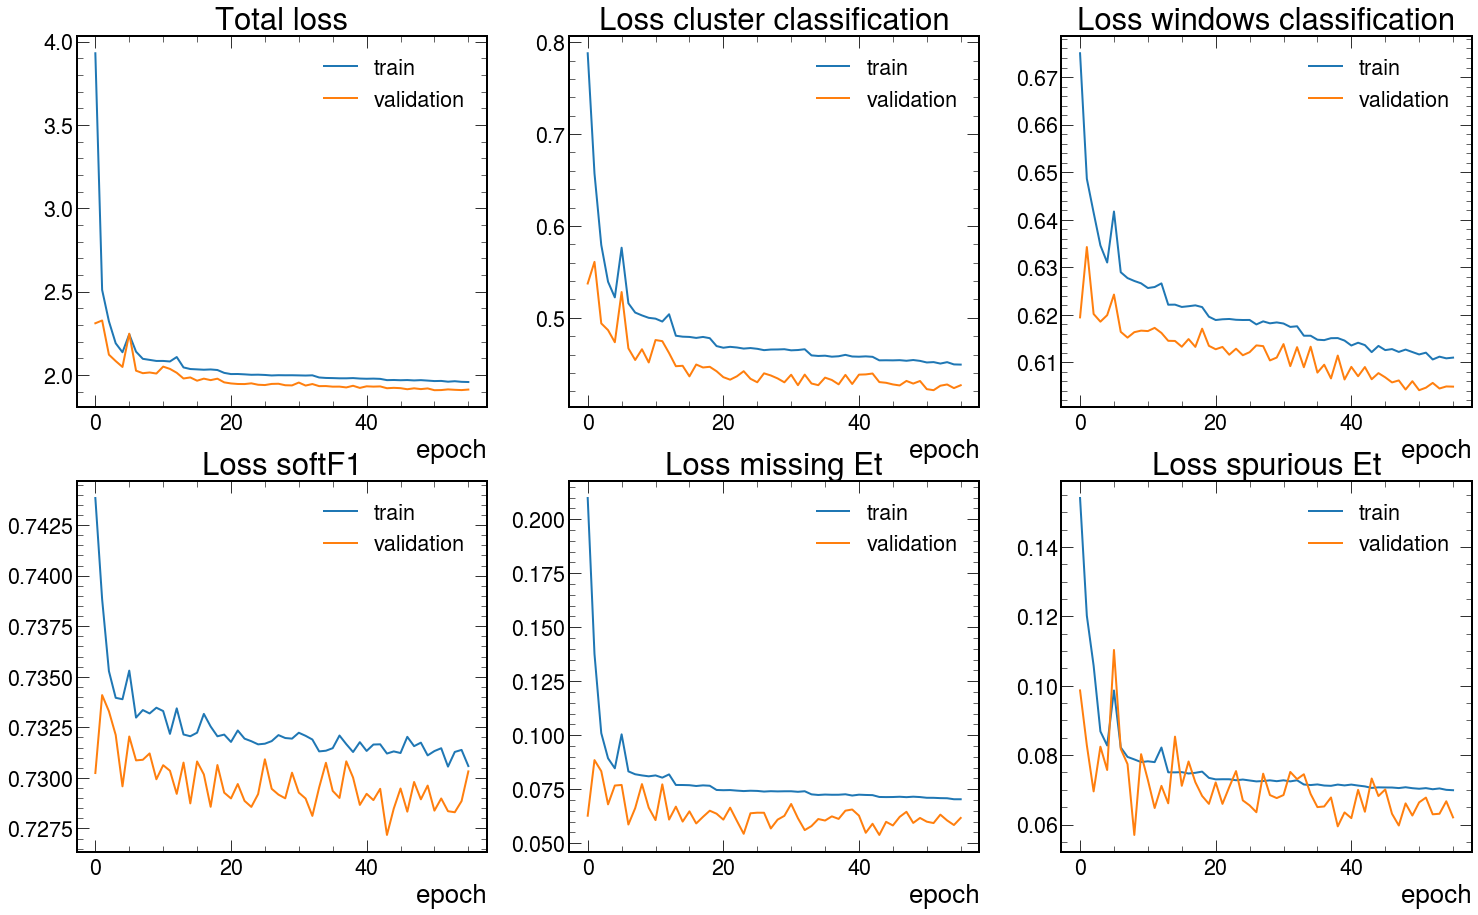

In [81]:
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25, 15))

ax1.plot(ret.history["loss"], label="train", linewidth=2)
ax1.plot(ret.history["val_loss"],label="validation", linewidth=2)
ax1.set_title("Total loss")
ax1.set_xlabel("epoch")
ax1.legend()

ax2.plot(ret.history["loss_clusters"], label="train", linewidth=2)
ax2.plot(ret.history["val_loss_clusters"],label="validation", linewidth=2)
ax2.set_title("Loss cluster classification")
ax2.set_xlabel("epoch")
ax2.legend()

ax3.plot(ret.history["loss_windows"], label="train", linewidth=2)
ax3.plot(ret.history["val_loss_windows"],label="validation", linewidth=2)
ax3.set_title("Loss windows classification")
ax3.set_xlabel("epoch")
ax3.legend()

ax4.plot(ret.history["loss_softF1"], label="train", linewidth=2)
ax4.plot(ret.history["val_loss_softF1"],label="validation", linewidth=2)
ax4.set_title("Loss softF1")
ax4.set_xlabel("epoch")
ax4.legend()

ax5.plot(ret.history["loss_et_miss"], label="train", linewidth=2)
ax5.plot(ret.history["val_loss_et_miss"],label="validation", linewidth=2)
ax5.set_title("Loss missing Et")
ax5.set_xlabel("epoch")
ax5.legend()

ax6.plot(ret.history["loss_et_spur"], label="train", linewidth=2)
ax6.plot(ret.history["val_loss_et_spur"],label="validation", linewidth=2)
ax6.set_title("Loss spurious Et")
ax6.set_xlabel("epoch")
ax6.legend()

f.savefig(outdir + "/train_loss.png")


In [82]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))
    
model.save(outdir+"/model")
    

AttributeError: 'GraphBuilding' object has no attribute 'coord_dim_sa'

### Test loss

In [111]:
X,y_true= tf_data.get(ds_test)

In [112]:
y_pred = model(X)

In [117]:
dense_clclass,dense_windclass, mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, y_metadata = y_true
y_target = tf.cast(y_clclass, tf.float32) 

pred_prob = tf.nn.sigmoid(dense_clclass)
diff = tf.math.abs(y_target - pred_prob)
Et = cl_X[:,:,1:2]

missing_en = Et * diff * y_target
spurious_en =  Et * diff * (1 - y_target)

reduced_loss_missing = tf.reduce_mean(tf.reduce_sum(missing_en, axis=1)) 
reduced_loss_spurious =  tf.reduce_mean(tf.reduce_sum(spurious_en, axis=1))

In [160]:
dense_clclass,dense_windclass, mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, y_metadata = y_true
y_target = tf.cast(y_clclass, tf.float32) 

pred_prob = tf.nn.sigmoid(dense_clclass)

In [169]:
tp = pred_prob * y_target
fn = (1 - pred_prob) * y_target
fp = pred_prob * (1 - y_target)

In [182]:
tptot = tf.reduce_sum(tp, axis=1)
fntot = tf.reduce_sum(fn, axis=1)
fptot = tf.reduce_sum(fp, axis=1)

In [187]:
1 - (2 * tptot)/ (2*tptot + fntot + fptot + 1e-16) 

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[0.8643937 ],
       [0.8417007 ],
       [0.7678521 ],
       [0.8621445 ],
       [0.8818361 ],
       [0.6749588 ],
       [0.86786455],
       [0.84230775],
       [0.8560391 ],
       [0.84797996],
       [0.8713441 ],
       [0.8565036 ],
       [0.87739176],
       [0.86709696],
       [0.855233  ],
       [0.86079264],
       [0.8512083 ],
       [0.86182773],
       [0.68536377],
       [0.8597818 ],
       [0.86351144],
       [0.863147  ],
       [0.85580873],
       [0.85421795],
       [0.87876534],
       [0.8604276 ],
       [0.86217374],
       [0.8579935 ],
       [0.86134374],
       [0.8482436 ],
       [0.8498958 ],
       [0.8549104 ],
       [0.8570379 ],
       [0.8734256 ],
       [0.8786647 ],
       [0.8799868 ],
       [0.8757078 ],
       [0.8537595 ],
       [0.8767978 ],
       [0.86964816],
       [0.8642583 ],
       [0.85530466],
       [0.86631775],
       [0.5863811 ],
       [0.85295665],
     

In [130]:
reduced_loss_spurious

<tf.Tensor: shape=(), dtype=float32, numpy=0.064462475>

### Layers inspection

In [155]:
model.layers

In [156]:
graphbuild = model.layers[0]

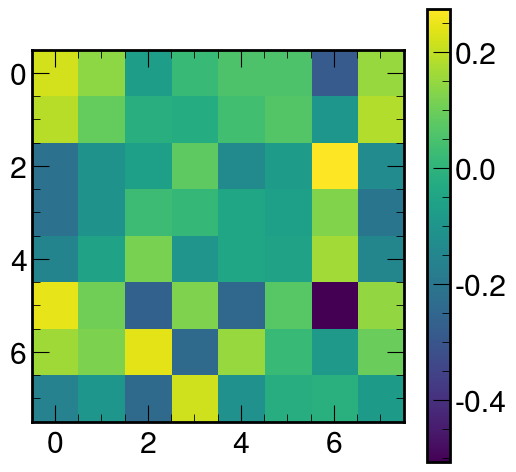

In [158]:
plotM(graphbuild.rechitsGCN.weights[2].numpy())

## Check metadata

In [154]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]


metadata =  [  "obsPU"]

In [165]:
data_path_train = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/training/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v6/training/calo_matched/*.proto",
                  #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
                  }


In [173]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
train_ds_ele = tf_data.load_dataset_single(data_path_train['ele_match'], options={'read_hits':False, 'read_metadata':True}).take(50000)
train_ds_gamma = tf_data.load_dataset_single(data_path_train['gamma_match'], options={'read_hits':False, 'read_metadata':True}).take(50000)
# the indexes for energy and et are from the features list we requestes
# train_ds = tf_data.delta_energy_seed(train_ds, en_index=0, et_index=1)
# train_ds = tf_data.training_format(train_ds)


In [158]:
import ROOT as R 

Welcome to JupyROOT 6.22/06


In [172]:
h_PU_ele = R.TH1F("hPUele","hPU", 50, 30,100)
h_PU_gamma = R.TH1F("hPUgamma","hPU", 50, 30,100)

Warning in <TROOT::Append>: Replacing existing TH1: hPUele (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hPUgamma (Potential memory leak).


In [160]:
mindex = tf_data.get_window_metadata_indexes(['obsPU'])

In [174]:
i = 0
for ev1, ev2 in zip(train_ds_ele, train_ds_gamma):
    if i%1000 ==0: print('.',end="")
    h_PU_ele.Fill(ev1[0]["w_m"][mindex[0]])
    h_PU_gamma.Fill(ev2[0]["w_m"][mindex[0]])
    i+=1

..................................................

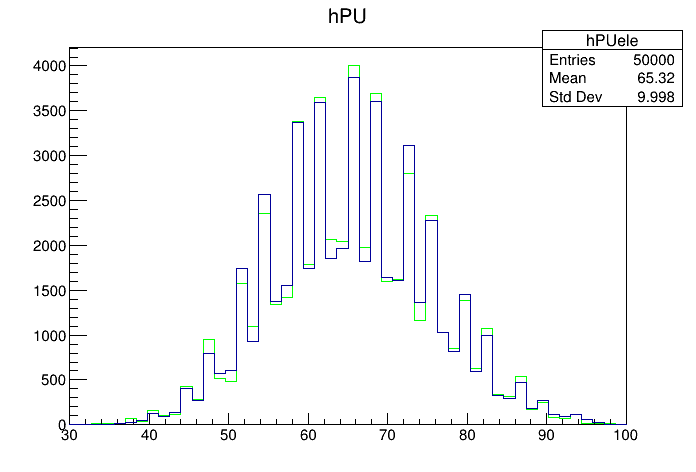

In [175]:
c = R.TCanvas()
h_PU_ele.Draw()
h_PU_ele.SetLineColor(R.kGreen)
h_PU_gamma.Draw("same")
c.Draw()

# Preliminary validation


In [131]:
from collections import defaultdict
data_calo = defaultdict(list)
data_nocalo = defaultdict(list)


for ib, (X, y_true) in enumerate(ds_test):
    if ib % 10 == 0: print(".",end="")
        
    y_out = model(X)
    
    cl_X_initial, wind_X_norm , cl_hits, is_seed,n_cl = X
    dense_clclass,dense_windclass, mask_cls, _  = y_out
    y_clclass, y_windclass, cl_X, wind_X, y_metadata = y_true
    y_target = tf.cast(y_clclass, tf.float32)

    pred_prob = tf.nn.sigmoid(dense_clclass)
    y_pred = tf.cast(pred_prob > 0.5, tf.float32)
    diff = tf.math.abs(y_target - pred_prob)
    Et = cl_X[:,:,1:2]    
    Et_true = tf.reduce_sum( tf.squeeze(Et * y_target),axis=1)
    Et_sel = tf.reduce_sum( tf.squeeze(Et * y_pred),axis=1)                   
    
    data_calo['seed_eta'].append(y_metadata[:, -2].numpy())
    data_calo['seed_et'].append(y_metadata[:, -1].numpy())
    data_calo['ncls'].append(n_cl.numpy())
    data_calo['ncls_true'].append(tf.reduce_sum(tf.squeeze(y_target), axis=-1).numpy())
    data_calo['ncls_sel'].append(tf.reduce_sum(tf.squeeze(y_pred), axis=-1).numpy())
    data_calo['ncls_sel_true'].append(tf.reduce_sum(tf.squeeze(y_pred*y_target), axis=-1).numpy())
    data_calo['Et_true'].append(Et_true.numpy())
    data_calo['Et_sel'].append(Et_sel.numpy())        
    data_calo['EoEtrue'].append((Et_sel/Et_true).numpy())          
    
    if ib ==150: break
    
    
#     for thr in thrs:
#         mask = tf.cast(ypred_onehot[:,:,1]  > thr, tf.float32).numpy()
#         mask_withseed = mask[:]
#         mask_withseed[:,0] = 1
#         pred_en = tf.reduce_sum( ens * mask_withseed, axis=-1)

#         tp =  tf.cast((in_sc_true * mask_withseed) ==1, tf.float32)
#         fp =  tf.cast((in_sc_true - mask_withseed) <0, tf.float32)
#         fn =  tf.cast((in_sc_true - mask_withseed) >0, tf.float32)

#         #do not count seeds for the ncls metrics
#         nclusters = X.shape[1] - padded - 1 
        
#         data_calo['thres'].append(thr* np.ones(tf.reduce_sum(tf.cast(calo_match_mask,tf.int32)).numpy()))
#         data_nocalo['thres'].append(thr* np.ones(tf.reduce_sum(tf.cast(nocalo_match_mask,tf.int32)).numpy()))
        
#         data_calo['seed_eta'].append(tf.boolean_mask(X_seed[:,0,0],calo_match_mask).numpy())
#         data_calo['seed_en'].append(tf.boolean_mask(X_seed[:,0,2],calo_match_mask).numpy())
#         data_calo['seed_et'].append(tf.boolean_mask(X_seed[:,0,3],calo_match_mask).numpy())
#         data_calo['ncls'].append(tf.boolean_mask(nclusters,calo_match_mask).numpy())
#         data_calo['ncls_sel'].append(tf.reduce_sum(tf.boolean_mask(mask_withseed, calo_match_mask),axis=-1).numpy() - 1)
#         data_calo['ncls_true'].append(tf.reduce_sum(tf.boolean_mask(in_sc_true,calo_match_mask), axis=-1).numpy() -1 )
#         data_calo['ncls_sel_true'].append(tf.reduce_sum(tf.boolean_mask(in_sc_true*mask_withseed, calo_match_mask),axis=-1).numpy() -1)
#         data_calo['seed_sel'].append(tf.boolean_mask(tf.cast(mask[:,0],tf.int32),calo_match_mask))
#         data_calo['EoEtrue'].append(tf.boolean_mask(pred_en / true_en, calo_match_mask).numpy())
#         data_calo['Etrue'].append(tf.boolean_mask(true_en, calo_match_mask).numpy())
#         data_calo['Epred'].append(tf.boolean_mask( pred_en, calo_match_mask).numpy())
#         data_calo['E_tp'].append(tf.boolean_mask( tf.reduce_sum(ens*tp, axis=-1), calo_match_mask).numpy())
#         data_calo['E_fp'].append(tf.boolean_mask( tf.reduce_sum(ens*fp, axis=-1), calo_match_mask).numpy())
#         data_calo['E_fn'].append(tf.boolean_mask( tf.reduce_sum(ens*fn, axis=-1), calo_match_mask).numpy())

#         data_nocalo['seed_eta'].append(tf.boolean_mask(X_seed[:,0,0],nocalo_match_mask).numpy())
#         data_nocalo['seed_en'].append(tf.boolean_mask(X_seed[:,0,2],nocalo_match_mask).numpy())
#         data_nocalo['seed_et'].append(tf.boolean_mask(X_seed[:,0,3],nocalo_match_mask).numpy())
#         data_nocalo['ncls'].append(tf.boolean_mask(nclusters,nocalo_match_mask).numpy()+1)
#         data_nocalo['ncls_sel'].append(tf.reduce_sum(tf.boolean_mask(mask, nocalo_match_mask),axis=-1).numpy())
#         data_nocalo['ncls_true'].append(tf.reduce_sum(tf.boolean_mask(in_sc_true,nocalo_match_mask), axis=-1).numpy())
#         data_nocalo['ncls_sel_true'].append(tf.reduce_sum(tf.boolean_mask(in_sc_true*mask_withseed, nocalo_match_mask),axis=-1).numpy())
#         data_nocalo['Econt'].append(tf.boolean_mask(pred_en, nocalo_match_mask).numpy())
#         data_nocalo['seed_sel'].append(tf.boolean_mask(tf.cast(mask[:,0],tf.int32),nocalo_match_mask))
    
    #if ib>4: break

................

In [132]:
data_final_calo = {}
# data_final_nocalo = {}

for k,v in data_calo.items():
    data_final_calo[k] = np.concatenate(v)
    
# for k,v in data_nocalo.items():
#     data_final_nocalo[k] = np.concatenate(v)
    
import pandas as pd
dfc = pd.DataFrame(data_final_calo)
# dfnc = pd.DataFrame(data_final_nocalo)

In [133]:
dfc.head()

,seed_eta,seed_et,ncls,ncls_true,ncls_sel,ncls_sel_true,Et_true,Et_sel,EoEtrue
0,0.0,0.0,7,1.0,1.0,1.0,1.010867,1.010867,1.0
1,2.0,22.0,3,1.0,1.0,1.0,92.604622,92.604622,1.0
2,0.0,0.0,5,1.0,1.0,1.0,2.476812,2.476812,1.0
3,0.0,0.0,4,1.0,1.0,1.0,0.872048,0.872048,1.0
4,2.0,11.0,7,2.0,2.0,2.0,93.212196,93.212196,1.0


In [134]:
ets = [0,5,10,15, 20,40,60,80,100]
etas = [0, 0.4,0.8, 1.2,1.479, 1.75,2.,2.3,2.6,3]
ncls = [1,2,3,5,10,12,15,17,20,25]

dfc["eta_bin"] = pd.cut(abs(dfc.seed_eta), etas, labels=list(range(len(etas)-1)))
dfc["et_bin"] = pd.cut(dfc.seed_et, ets, labels=list(range(len(ets)-1)))
dfc["ncls_bin"] = pd.cut(dfc.ncls, ncls, labels=list(range(len(ncls)-1)))

In [135]:
mask_EB_eta1 = (abs(dfc.seed_eta)<1)
mask_EB_eta2 = (abs(dfc.seed_eta)>=1) & (abs(dfc.seed_eta)<1.497)
mask_EE_eta1 = (abs(dfc.seed_eta)>=1.479) & (abs(dfc.seed_eta)<2)
mask_EE_eta2 = (abs(dfc.seed_eta)>=2) & (abs(dfc.seed_eta)<3)
masks = [mask_EB_eta1,mask_EB_eta2,mask_EE_eta1,mask_EE_eta2]

/usr/local/bin/start_ipykernel.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
W0524 00:18:15.769901 140330860369728 font_manager.py:1357] findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


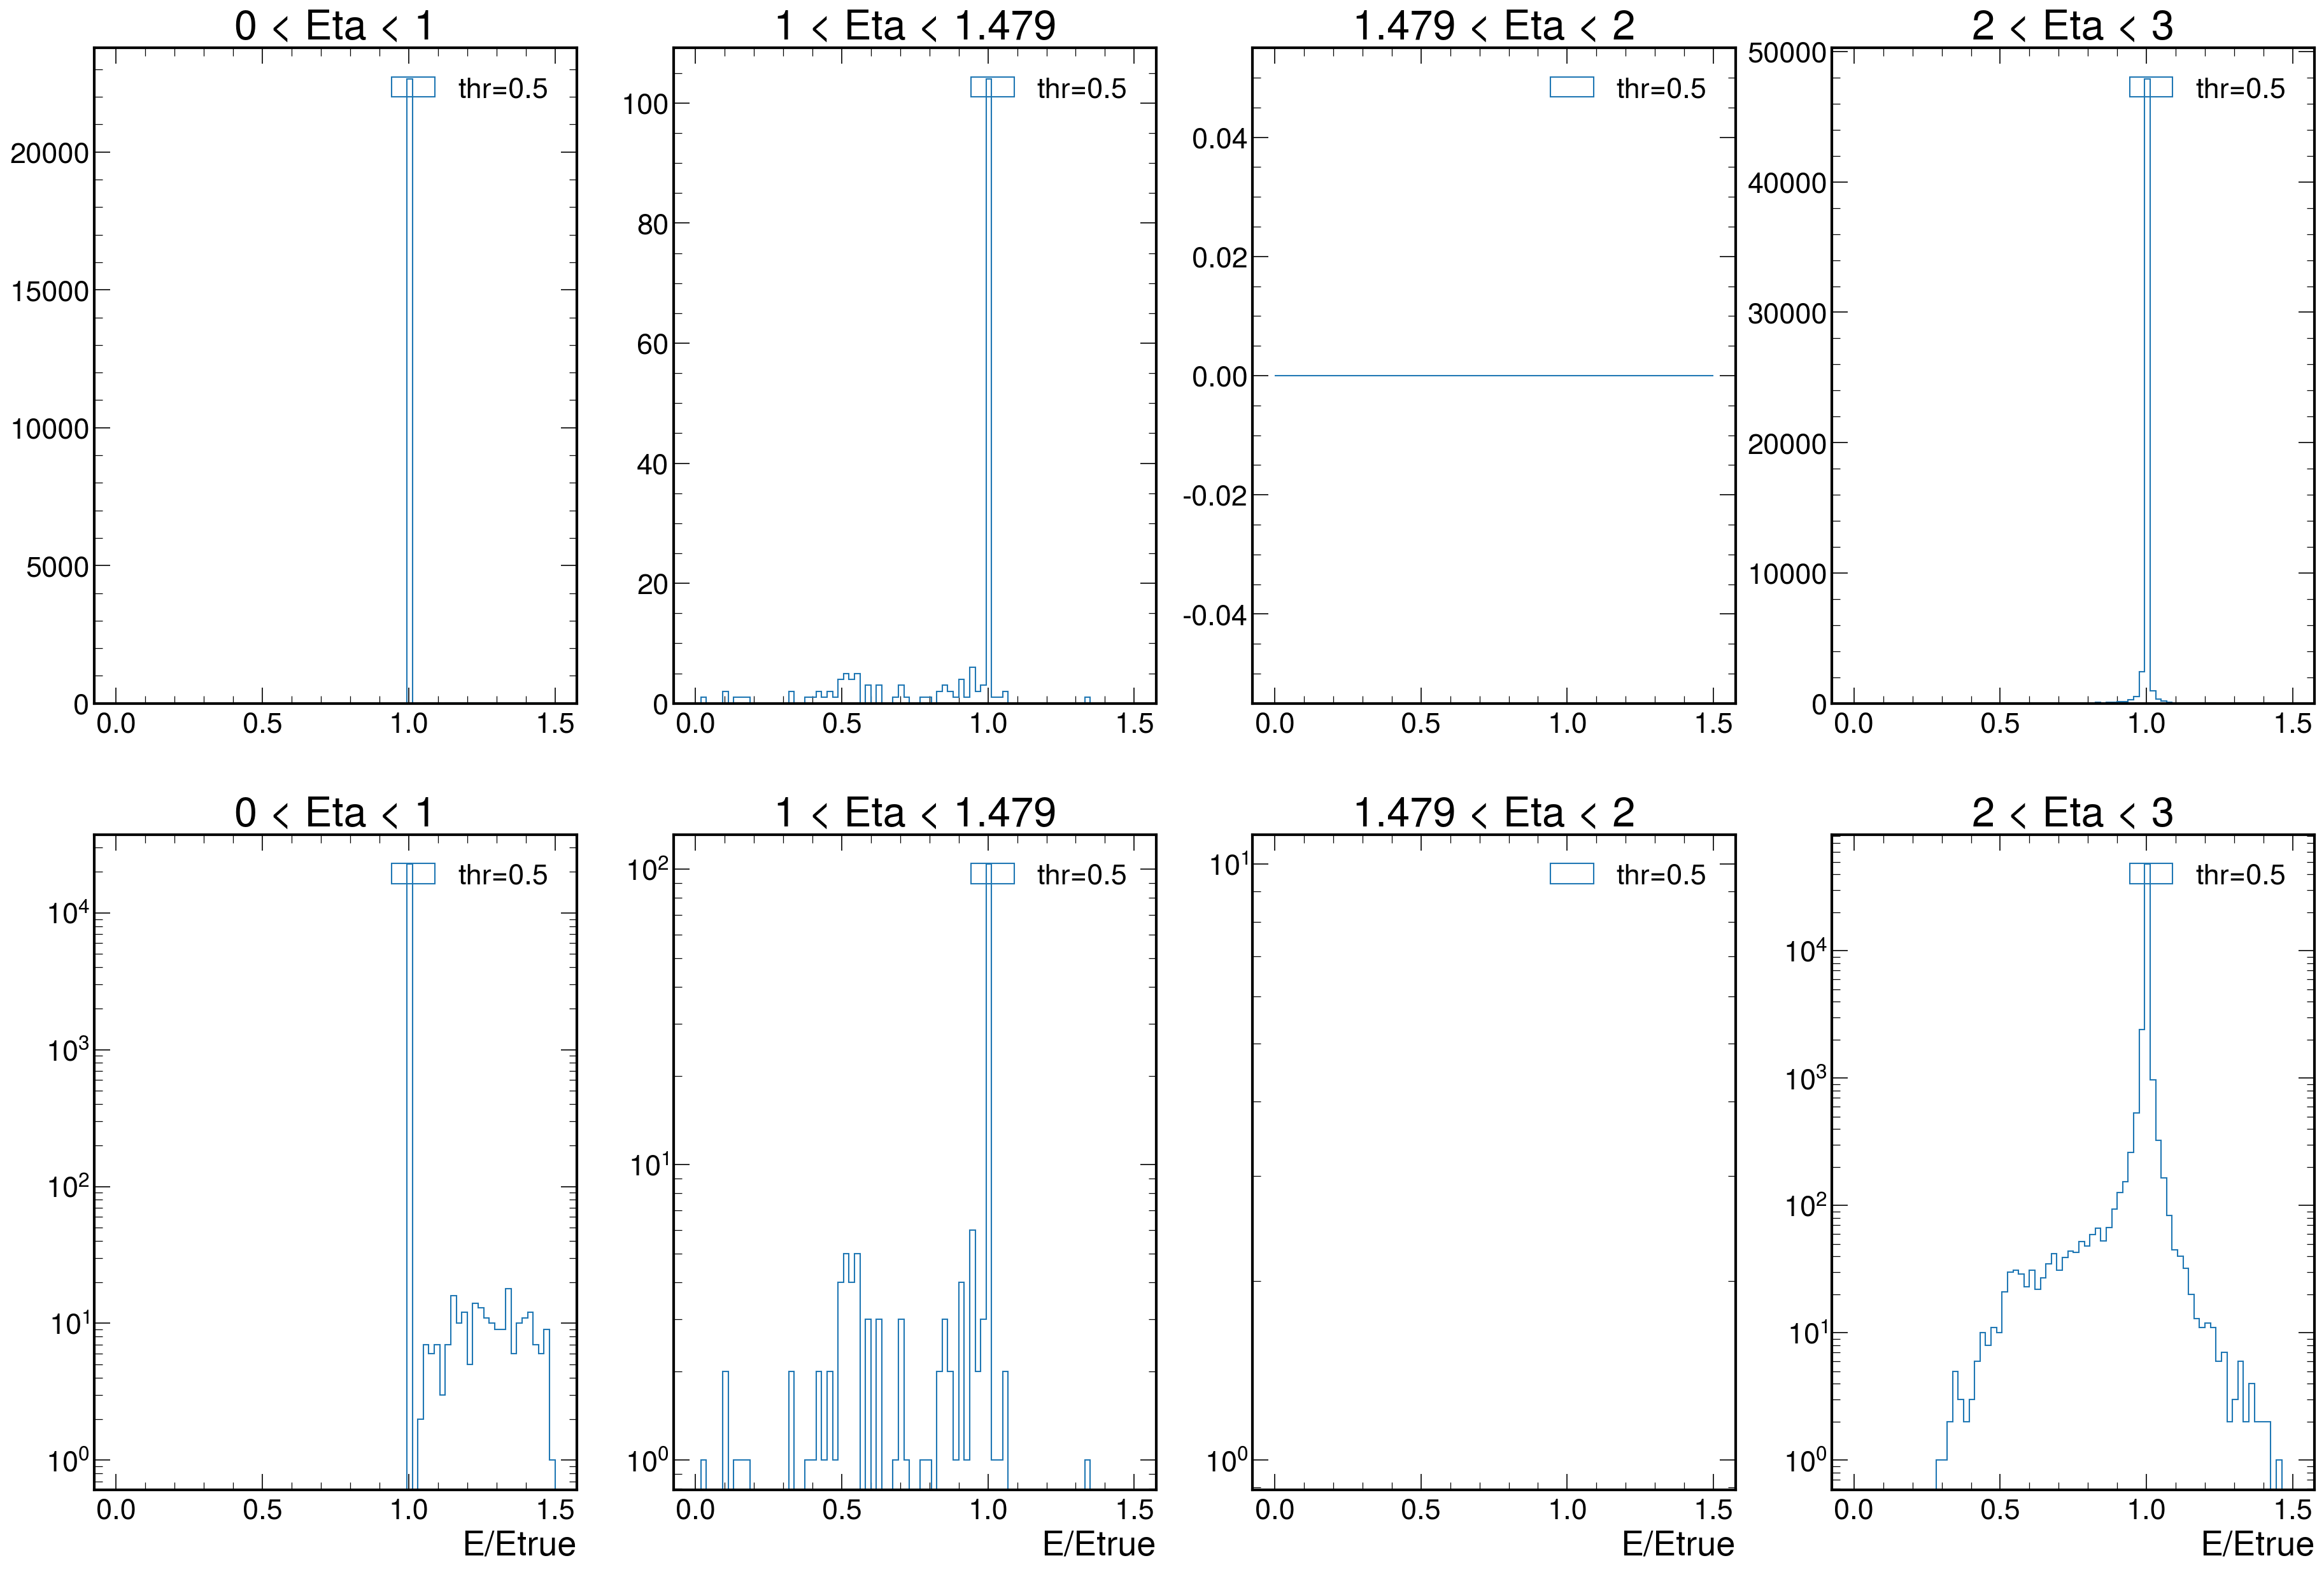

In [136]:
fig, ax = plt.subplots(2,4, figsize=(30,20),dpi=150)

etas = [ (0,1),(1,1.479),(1.479,2), (2,3)]

for j,(e1,e2) in enumerate(etas): 
    ax[0,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].EoEtrue,bins=80, range=(0,1.5),histtype='step', label='thr=0.5')
    ax[0,j].legend()
    ax[0,j].set_title('{} < Eta < {}'.format(e1,e2))   
    ax[1,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].EoEtrue,bins=80, range=(0,1.5),histtype='step', label='thr=0.5')
    ax[1,j].legend()
    ax[1,j].set_xlabel("E/Etrue")
    ax[1,j].set_title('{} < Eta < {}'.format(e1,e2))  
    ax[1,j].set_yscale('log')



/usr/local/bin/start_ipykernel.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/usr/local/bin/start_ipykernel.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


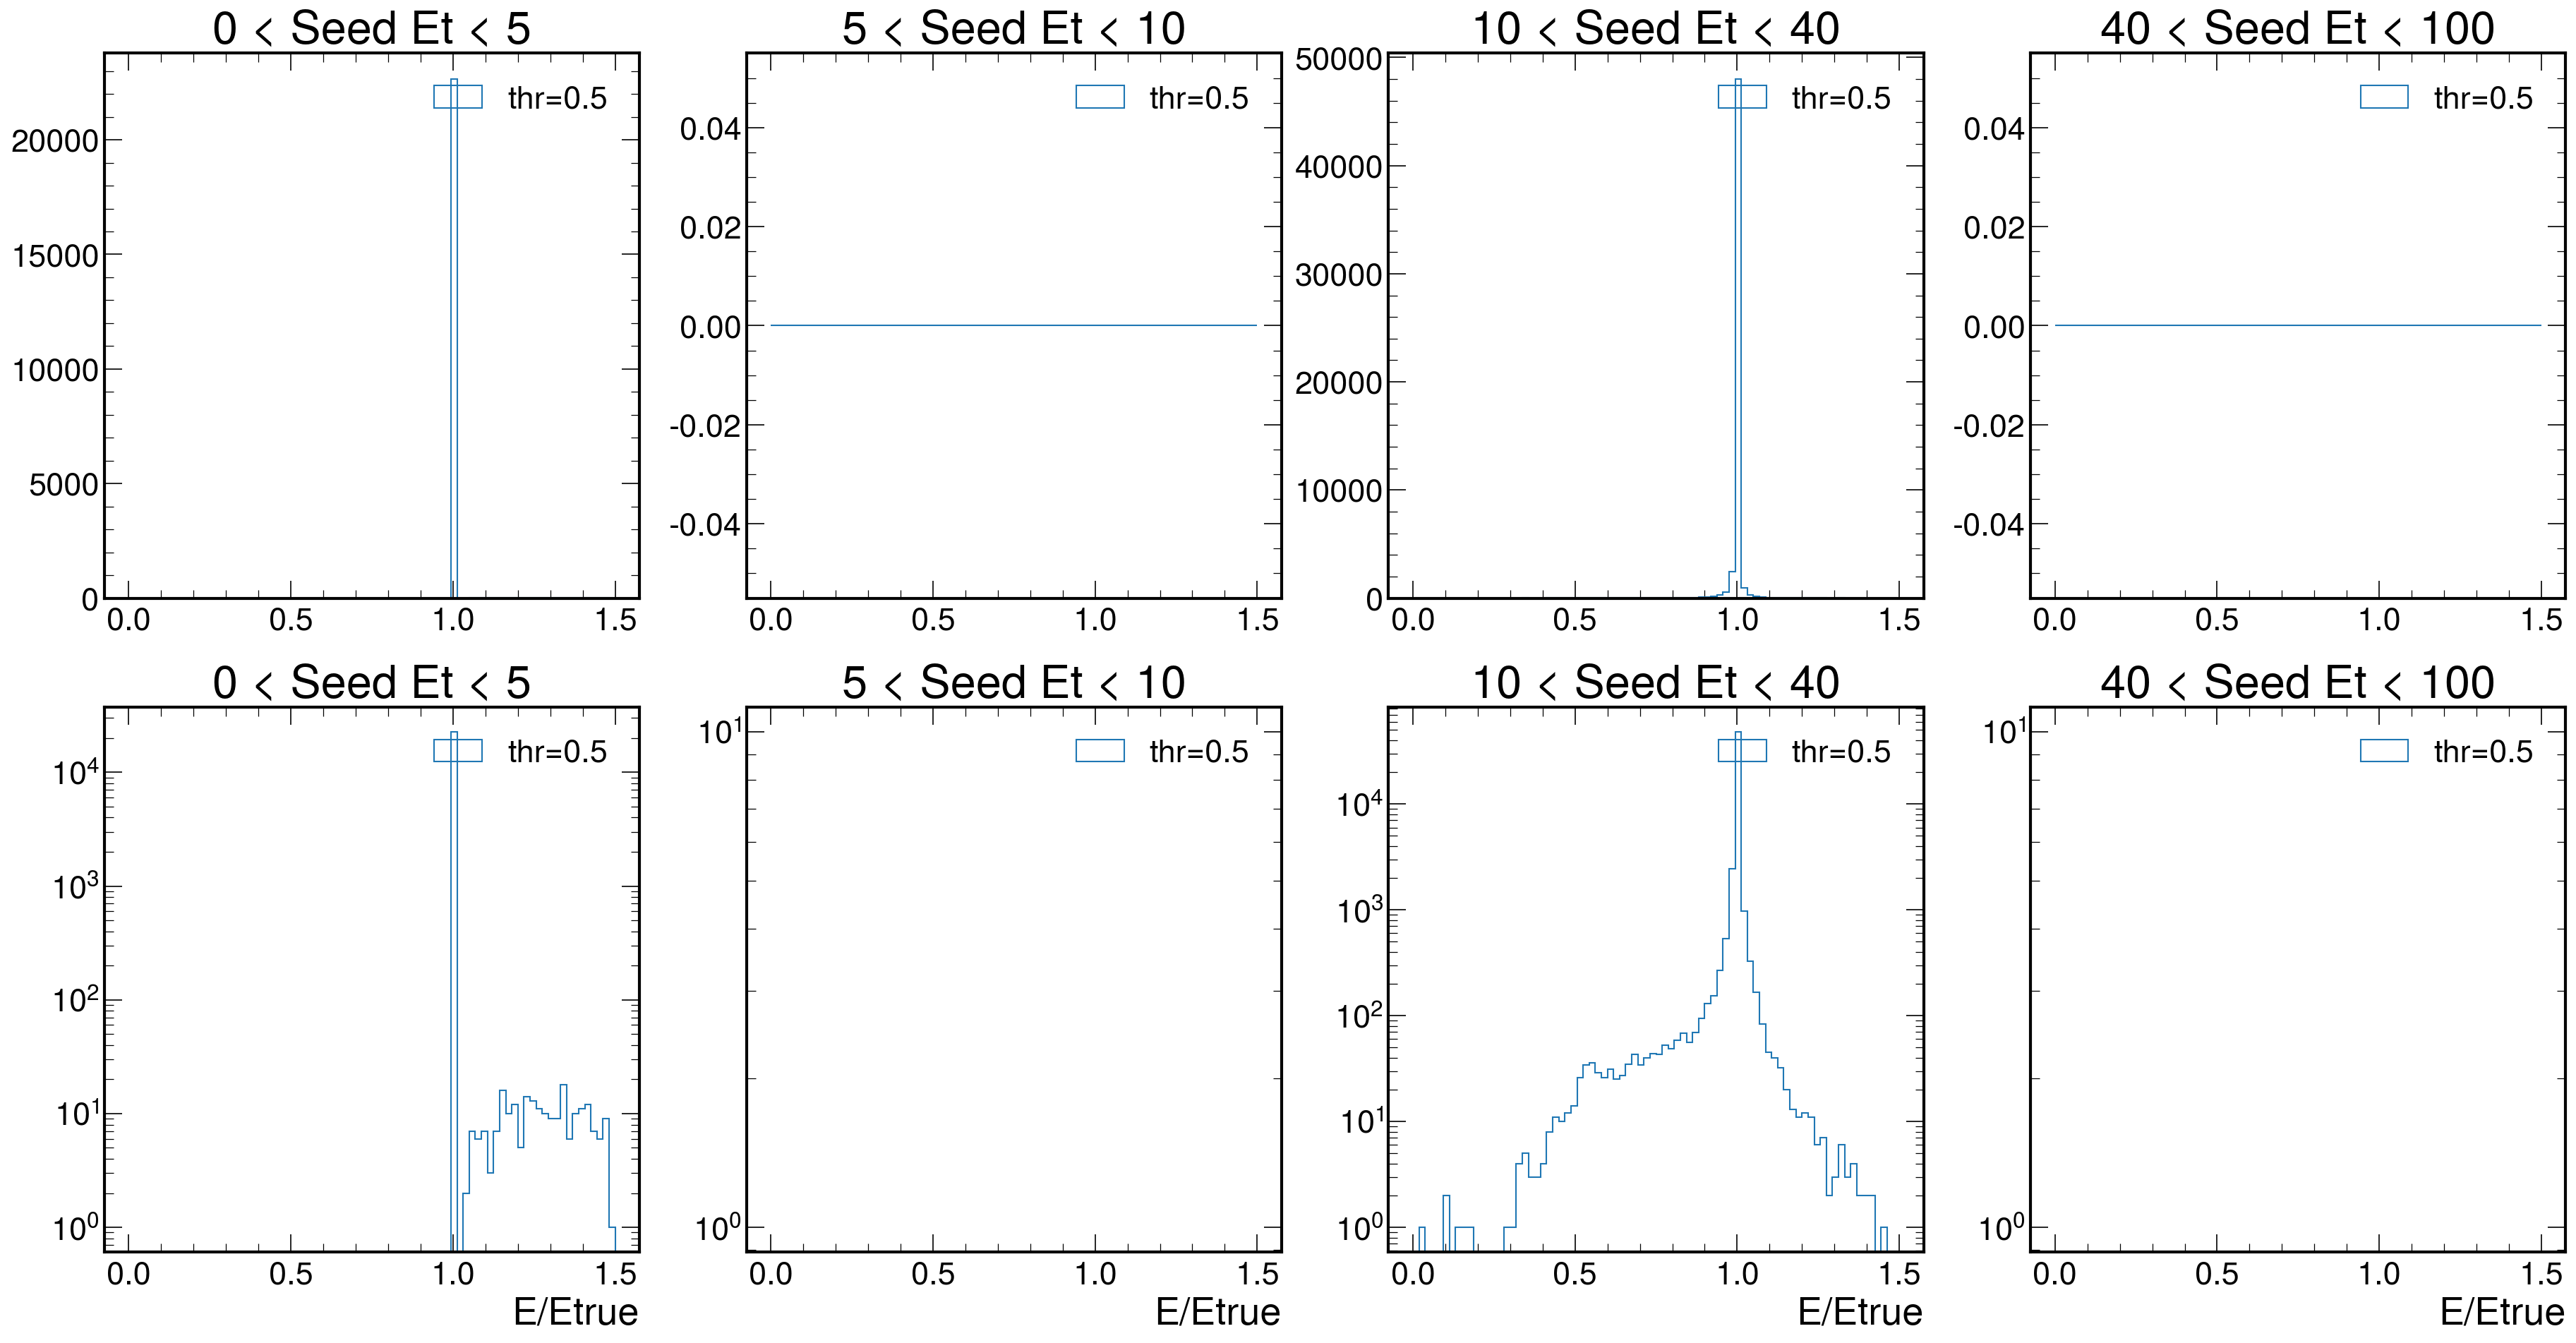

In [137]:
fig, ax = plt.subplots(2,4, figsize=(30,15),dpi=150)

ets = [ (0,5),(5,10),(10,40), (40,100)]

for j,(e1,e2) in enumerate(ets): 
        ax[0,j].hist(dfc[ (dfc.seed_et>=e1) & (dfc.seed_et<e2)].EoEtrue,bins=80, range=(0,1.5),histtype='step',label='thr=0.5')
        ax[0,j].legend()
        ax[0,j].set_title('{} < Seed Et < {}'.format(e1,e2))   
        ax[1,j].hist(dfc[(dfc.seed_et>=e1) & (dfc.seed_et<e2)].EoEtrue,bins=80, range=(0,1.5),histtype='step', label='thr=0.5')
        ax[1,j].legend()
        ax[1,j].set_xlabel("E/Etrue")
        ax[1,j].set_title('{} < Seed Et < {}'.format(e1,e2))  
        ax[1,j].set_yscale('log')


In [242]:
def plot_eteta2D(data, title, zlabel="",**kwargs):

    a = data.values.reshape((len(etas)-1,len(ets)-1))

    plt.figure(figsize=(10,5))
    plt.imshow(a.T,**kwargs)
    plt.xlabel("Seed $\eta$")
    plt.ylabel("Seed $E_T$")
    plt.title(title)
    plt.colorbar(label=zlabel)

    plt.yticks(np.arange(len(ets)-1), ets)
    plt.xticks(np.arange(len(etas)-1), etas)

    locs, labels= plt.xticks()
    labels.append(etas[-1])
    locs = np.append(locs, [len(etas)-1])
    plt.xticks(locs-0.5, labels)

    locs, labels= plt.yticks()
    labels.append(ets[-1])
    locs = np.append(locs, [len(ets)-1])
    plt.yticks(locs-0.5, labels)

def plot_nclseta2D(data, title, zlabel="", **kwargs):

    a = data.values.reshape((len(etas)-1,len(ncls)-1))

    plt.figure(figsize=(10,5))
    plt.imshow(a.T, **kwargs)
    plt.xlabel("Seed $\eta$")
    plt.ylabel("N. clusters")
    plt.title(title)
    plt.colorbar(label=zlabel)

    plt.yticks(np.arange(len(ncls)-1), ncls)
    plt.xticks(np.arange(len(etas)-1), etas)

    locs, labels= plt.xticks()
    labels.append(etas[-1])
    locs = np.append(locs, [len(etas)-1])
    plt.xticks(locs-0.5, labels)

    locs, labels= plt.yticks()
    labels.append(ncls[-1])
    locs = np.append(locs, [len(ncls)-1])
    plt.yticks(locs-0.5, labels)

/usr/local/bin/start_ipykernel.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/usr/local/bin/start_ipykernel.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/cvmfs/sft.cern.ch/lcg/views/LCG_99cuda/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


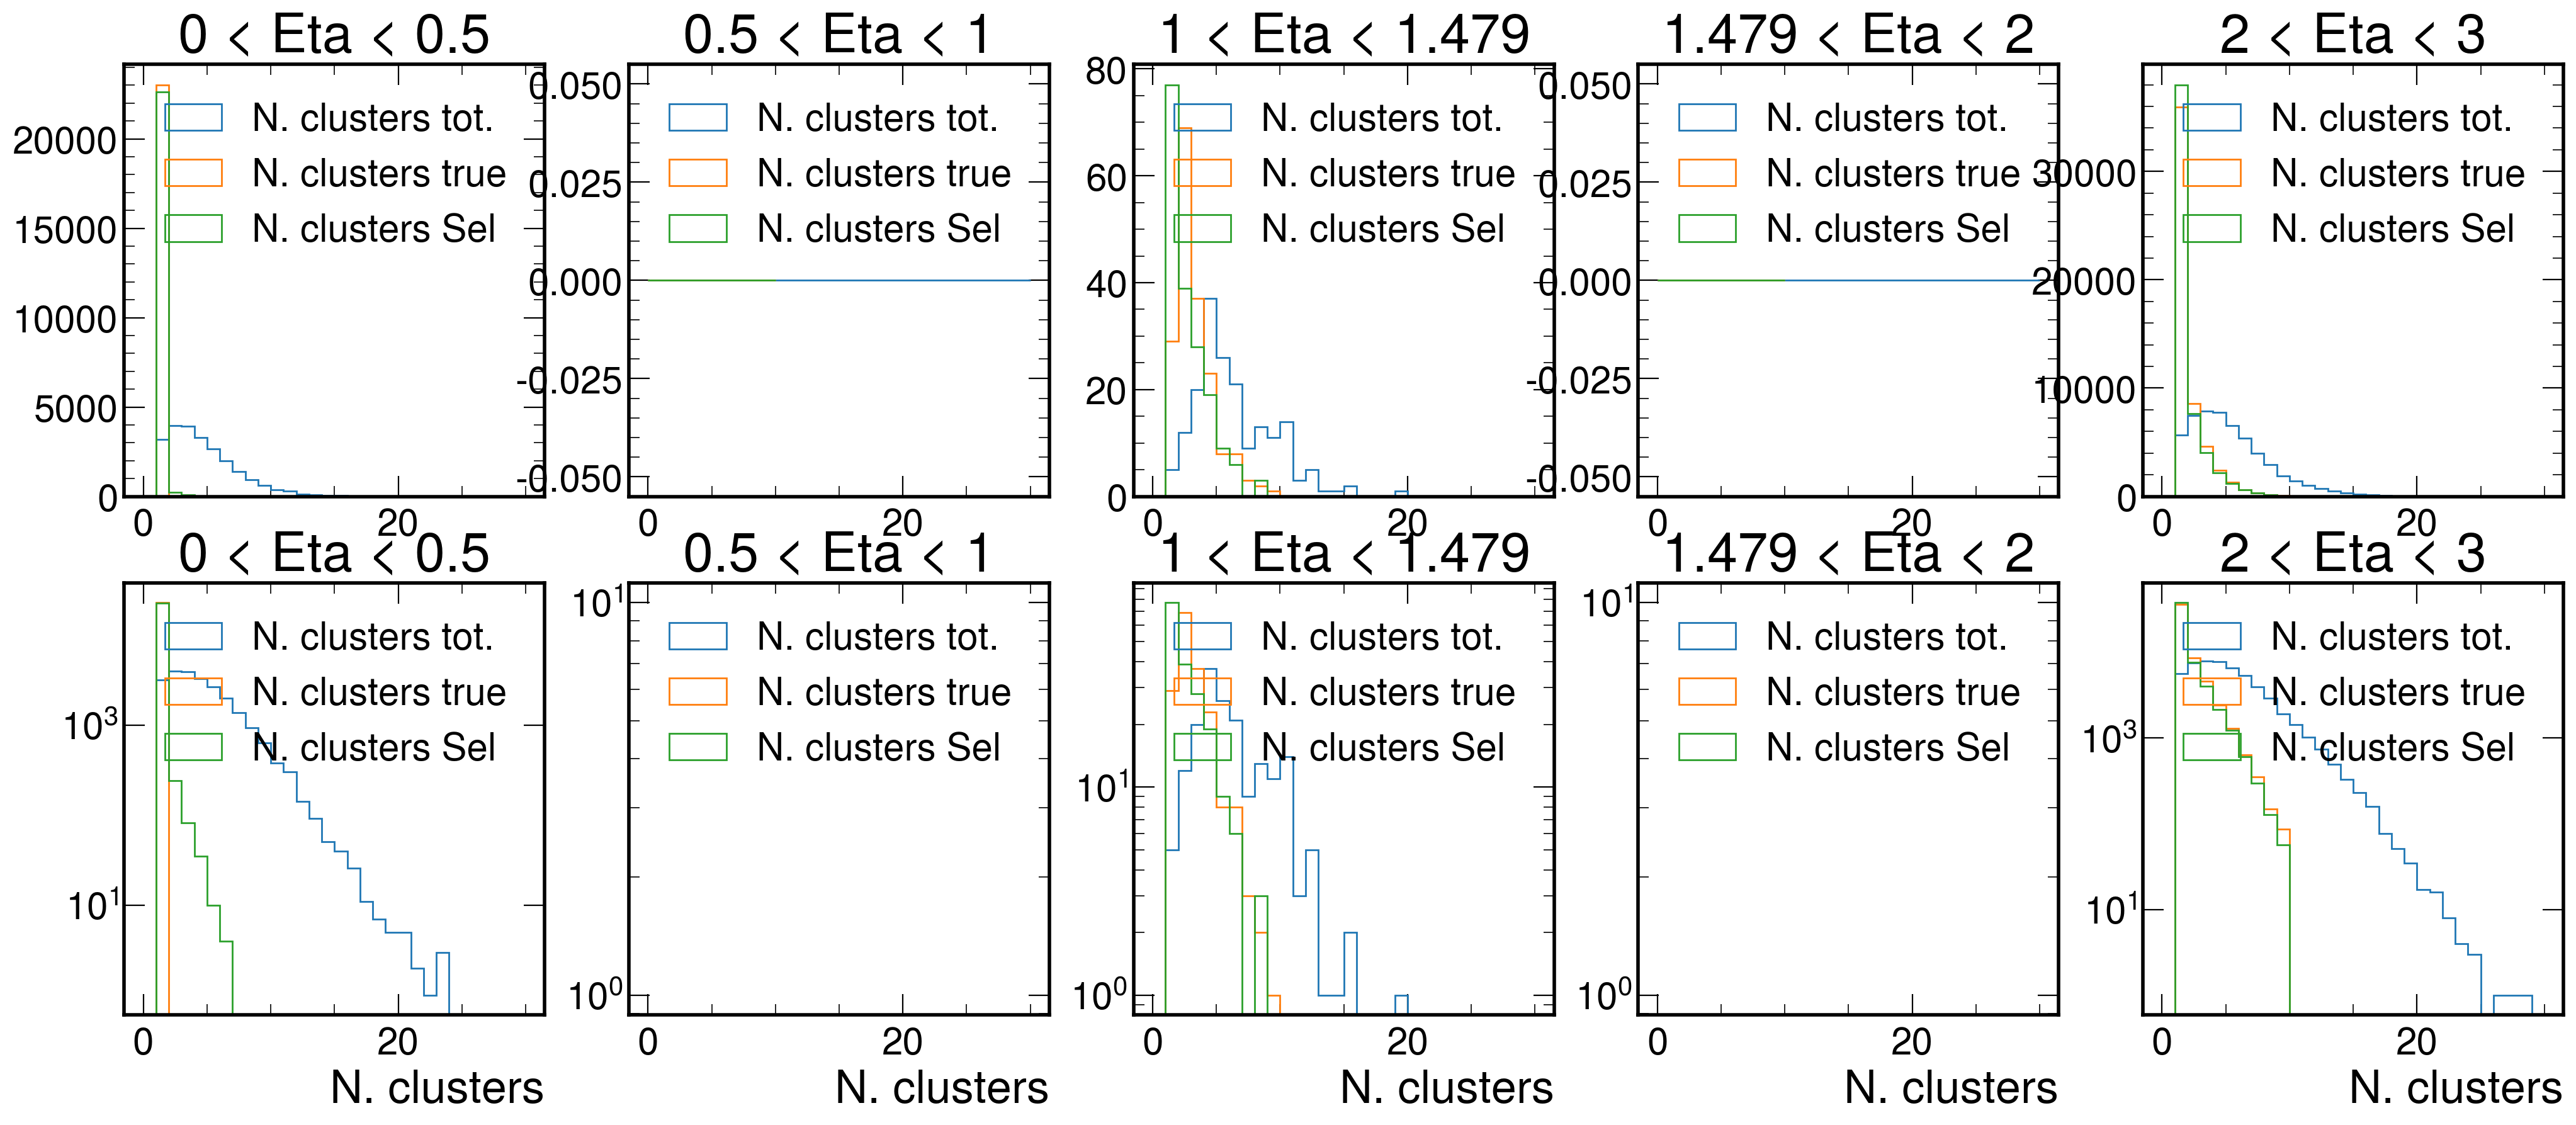

In [138]:
fig, ax = plt.subplots(2,5, figsize=(25,10),dpi=200)

etas = [ (0,0.5),(0.5,1),(1,1.479),(1.479,2), (2,3)]

for j,(e1,e2) in enumerate(etas): 
        ax[0,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].ncls,bins=30, range=(0,30),histtype='step', label="N. clusters tot.")
        ax[0,j].set_title('{} < Eta < {}'.format(e1,e2))   
        ax[1,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].ncls,bins=30, range=(0,30),histtype='step', label="N. clusters tot.")
        ax[1,j].set_xlabel("N. clusters")
        ax[1,j].set_title('{} < Eta < {}'.format(e1,e2))  
        ax[1,j].set_yscale('log')
        
        
        ax[0,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].ncls_true,bins=10, range=(0,10),histtype='step', label="N. clusters true")
        ax[0,j].set_title('{} < Eta < {}'.format(e1,e2))   
        ax[1,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].ncls_true,bins=10, range=(0,10),histtype='step', label="N. clusters true")
        ax[1,j].set_xlabel("N. clusters")
        ax[1,j].set_title('{} < Eta < {}'.format(e1,e2))  
        ax[1,j].set_yscale('log')
        
        ax[0,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].ncls_sel,bins=10, range=(0,10),histtype='step', label="N. clusters Sel")
        ax[1,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].ncls_sel,bins=10, range=(0,10),histtype='step', label="N. clusters Sel")
        
        
        ax[0,j].legend()
        ax[1,j].legend()



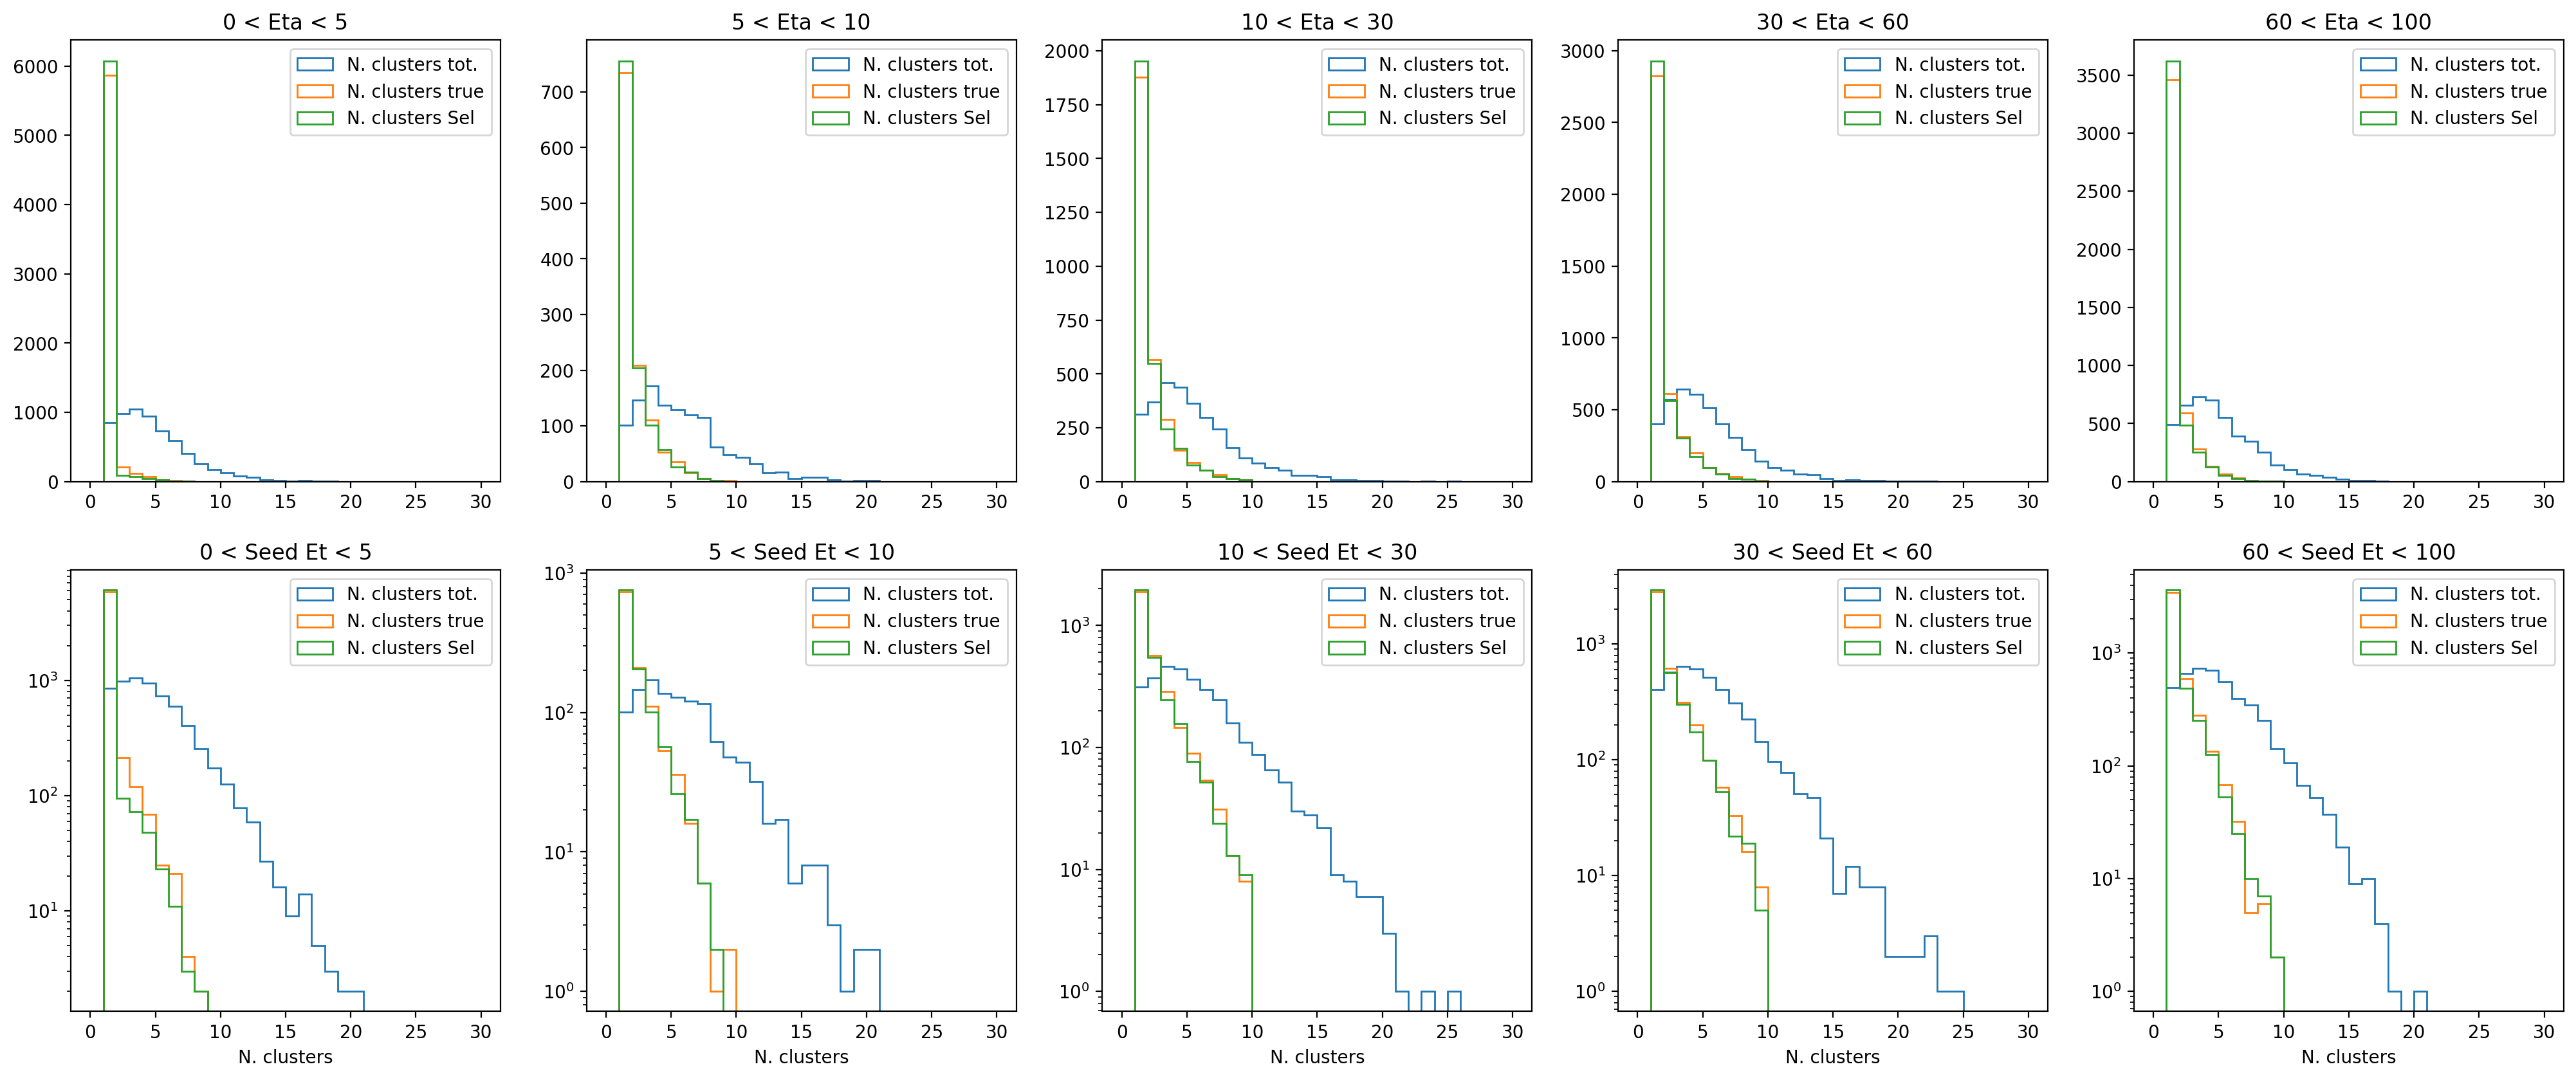

In [220]:
fig, ax = plt.subplots(2,5, figsize=(25,10),dpi=200)


ets = [ (0,5),(5,10),(10,30), (30,60),(60,100)]

for j,(e1,e2) in enumerate(ets): 
        ax[0,j].hist(dfc[(abs(dfc.seed_et)>=e1) & (abs(dfc.seed_et)<e2)].ncls,bins=30, range=(0,30),histtype='step', label="N. clusters tot.")
        ax[0,j].set_title('{} < Eta < {}'.format(e1,e2))   
        ax[1,j].hist(dfc[(abs(dfc.seed_et)>=e1) & (abs(dfc.seed_et)<e2)].ncls,bins=30, range=(0,30),histtype='step', label="N. clusters tot.")
        ax[1,j].set_xlabel("N. clusters")
        ax[1,j].set_title('{} < Seed Et < {}'.format(e1,e2))  
        ax[1,j].set_yscale('log')
        
        
        ax[0,j].hist(dfc[(abs(dfc.seed_et)>=e1) & (abs(dfc.seed_et)<e2)].ncls_true,bins=10, range=(0,10),histtype='step', label="N. clusters true")
        ax[1,j].hist(dfc[(abs(dfc.seed_et)>=e1) & (abs(dfc.seed_et)<e2)].ncls_true,bins=10, range=(0,10),histtype='step', label="N. clusters true")
        
        ax[0,j].hist(dfc[(abs(dfc.seed_et)>=e1) & (abs(dfc.seed_et)<e2)].ncls_sel,bins=10, range=(0,10),histtype='step', label="N. clusters Sel")
        ax[1,j].hist(dfc[(abs(dfc.seed_et)>=e1) & (abs(dfc.seed_et)<e2)].ncls_sel,bins=10, range=(0,10),histtype='step', label="N. clusters Sel")
        ax[0,j].legend()
        ax[1,j].legend()

In [249]:
result =  dfc[(dfc.ncls_true >0)].groupby(["eta_bin", "ncls_bin"])\
             .apply( lambda gr:  (gr.ncls_sel_true / gr.ncls_true).mean())\
             .unstack(fill_value=0).stack()

#plot_nclseta2D(result,"N. clusters recall", vmin=0.2, vmax=1)

In [251]:
result.values.shape

(81,)

In [254]:
len(ets)

10

([<matplotlib.axis.YTick at 0x7f8d7afe4e10>,
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '3'),
  Text(0, 3, '5'),
  Text(0, 4, '10'),
  Text(0, 5, '12'),
  Text(0, 6, '15'),
  Text(0, 7, '17'),
  Text(0, 8, '20'),
  Text(0, 9, '25')])

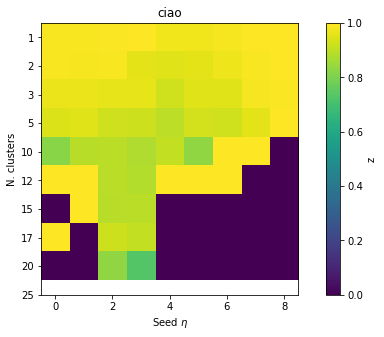

In [265]:
a = result.values.reshape((len(etas)-1,len(ncls)-1))

plt.figure(figsize=(10,5))
plt.imshow(a.T)
plt.xlabel("Seed $\eta$")
plt.ylabel("N. clusters")
plt.title("ciao")
plt.colorbar(label="z")


plt.yticks(np.arange(len(ncls)), ncls)
#plt.xticks(np.arange(len(etas)-1), etas)

In [ ]:

plt.yticks(np.arange(len(ets)-1), ets)
plt.xticks(np.arange(len(etas)-1), etas)

locs, labels= plt.xticks()
labels.append(etas[-1])
locs = np.append(locs, [len(etas)-1])
plt.xticks(locs-0.5, labels)

locs, labels= plt.yticks()
labels.append(ets[-1])
locs = np.append(locs, [len(ets)-1])
plt.yticks(locs-0.5, labels)

In [ ]:
result =  dfc.groupby(["eta_bin", "et_bin"]).EoEtrue.mean()

plot_eteta2D(result,"E/Etrue scale", vmin=0.5, vmax=1.2)